In [1]:
from skimage import io, morphology, color, util, filters
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="Set2")

data = "example/"

In [2]:
img  = io.imread(data + '1_fluorescence.jpg')
img_true  = io.imread(data + '1_brightfield.jpg')

img.shape

(5733, 3893, 3)

In [4]:
#img_gray = color.rgb2gray(img)
img_gray = img[:,:,2]

img_gray = util.img_as_ubyte(img_gray)
img_gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

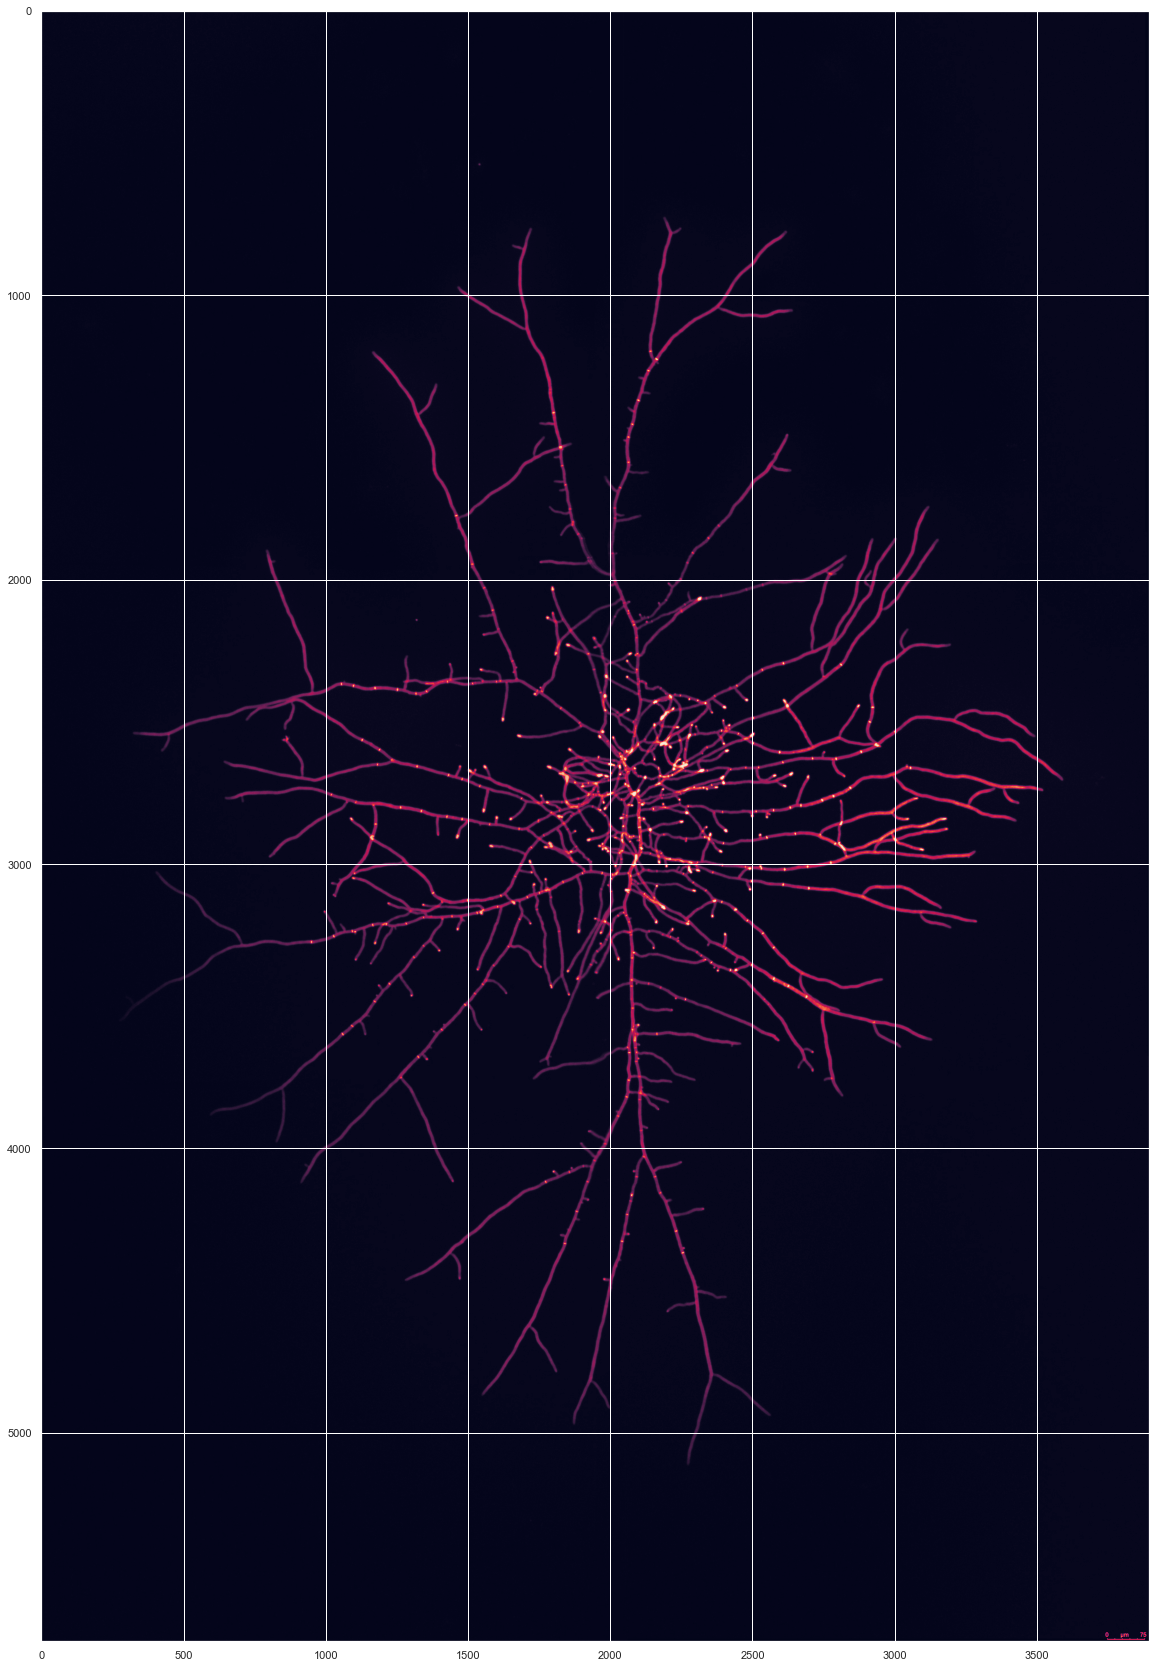

In [41]:
plt.figure(figsize=[40,30])
plt.imshow(img_gray)

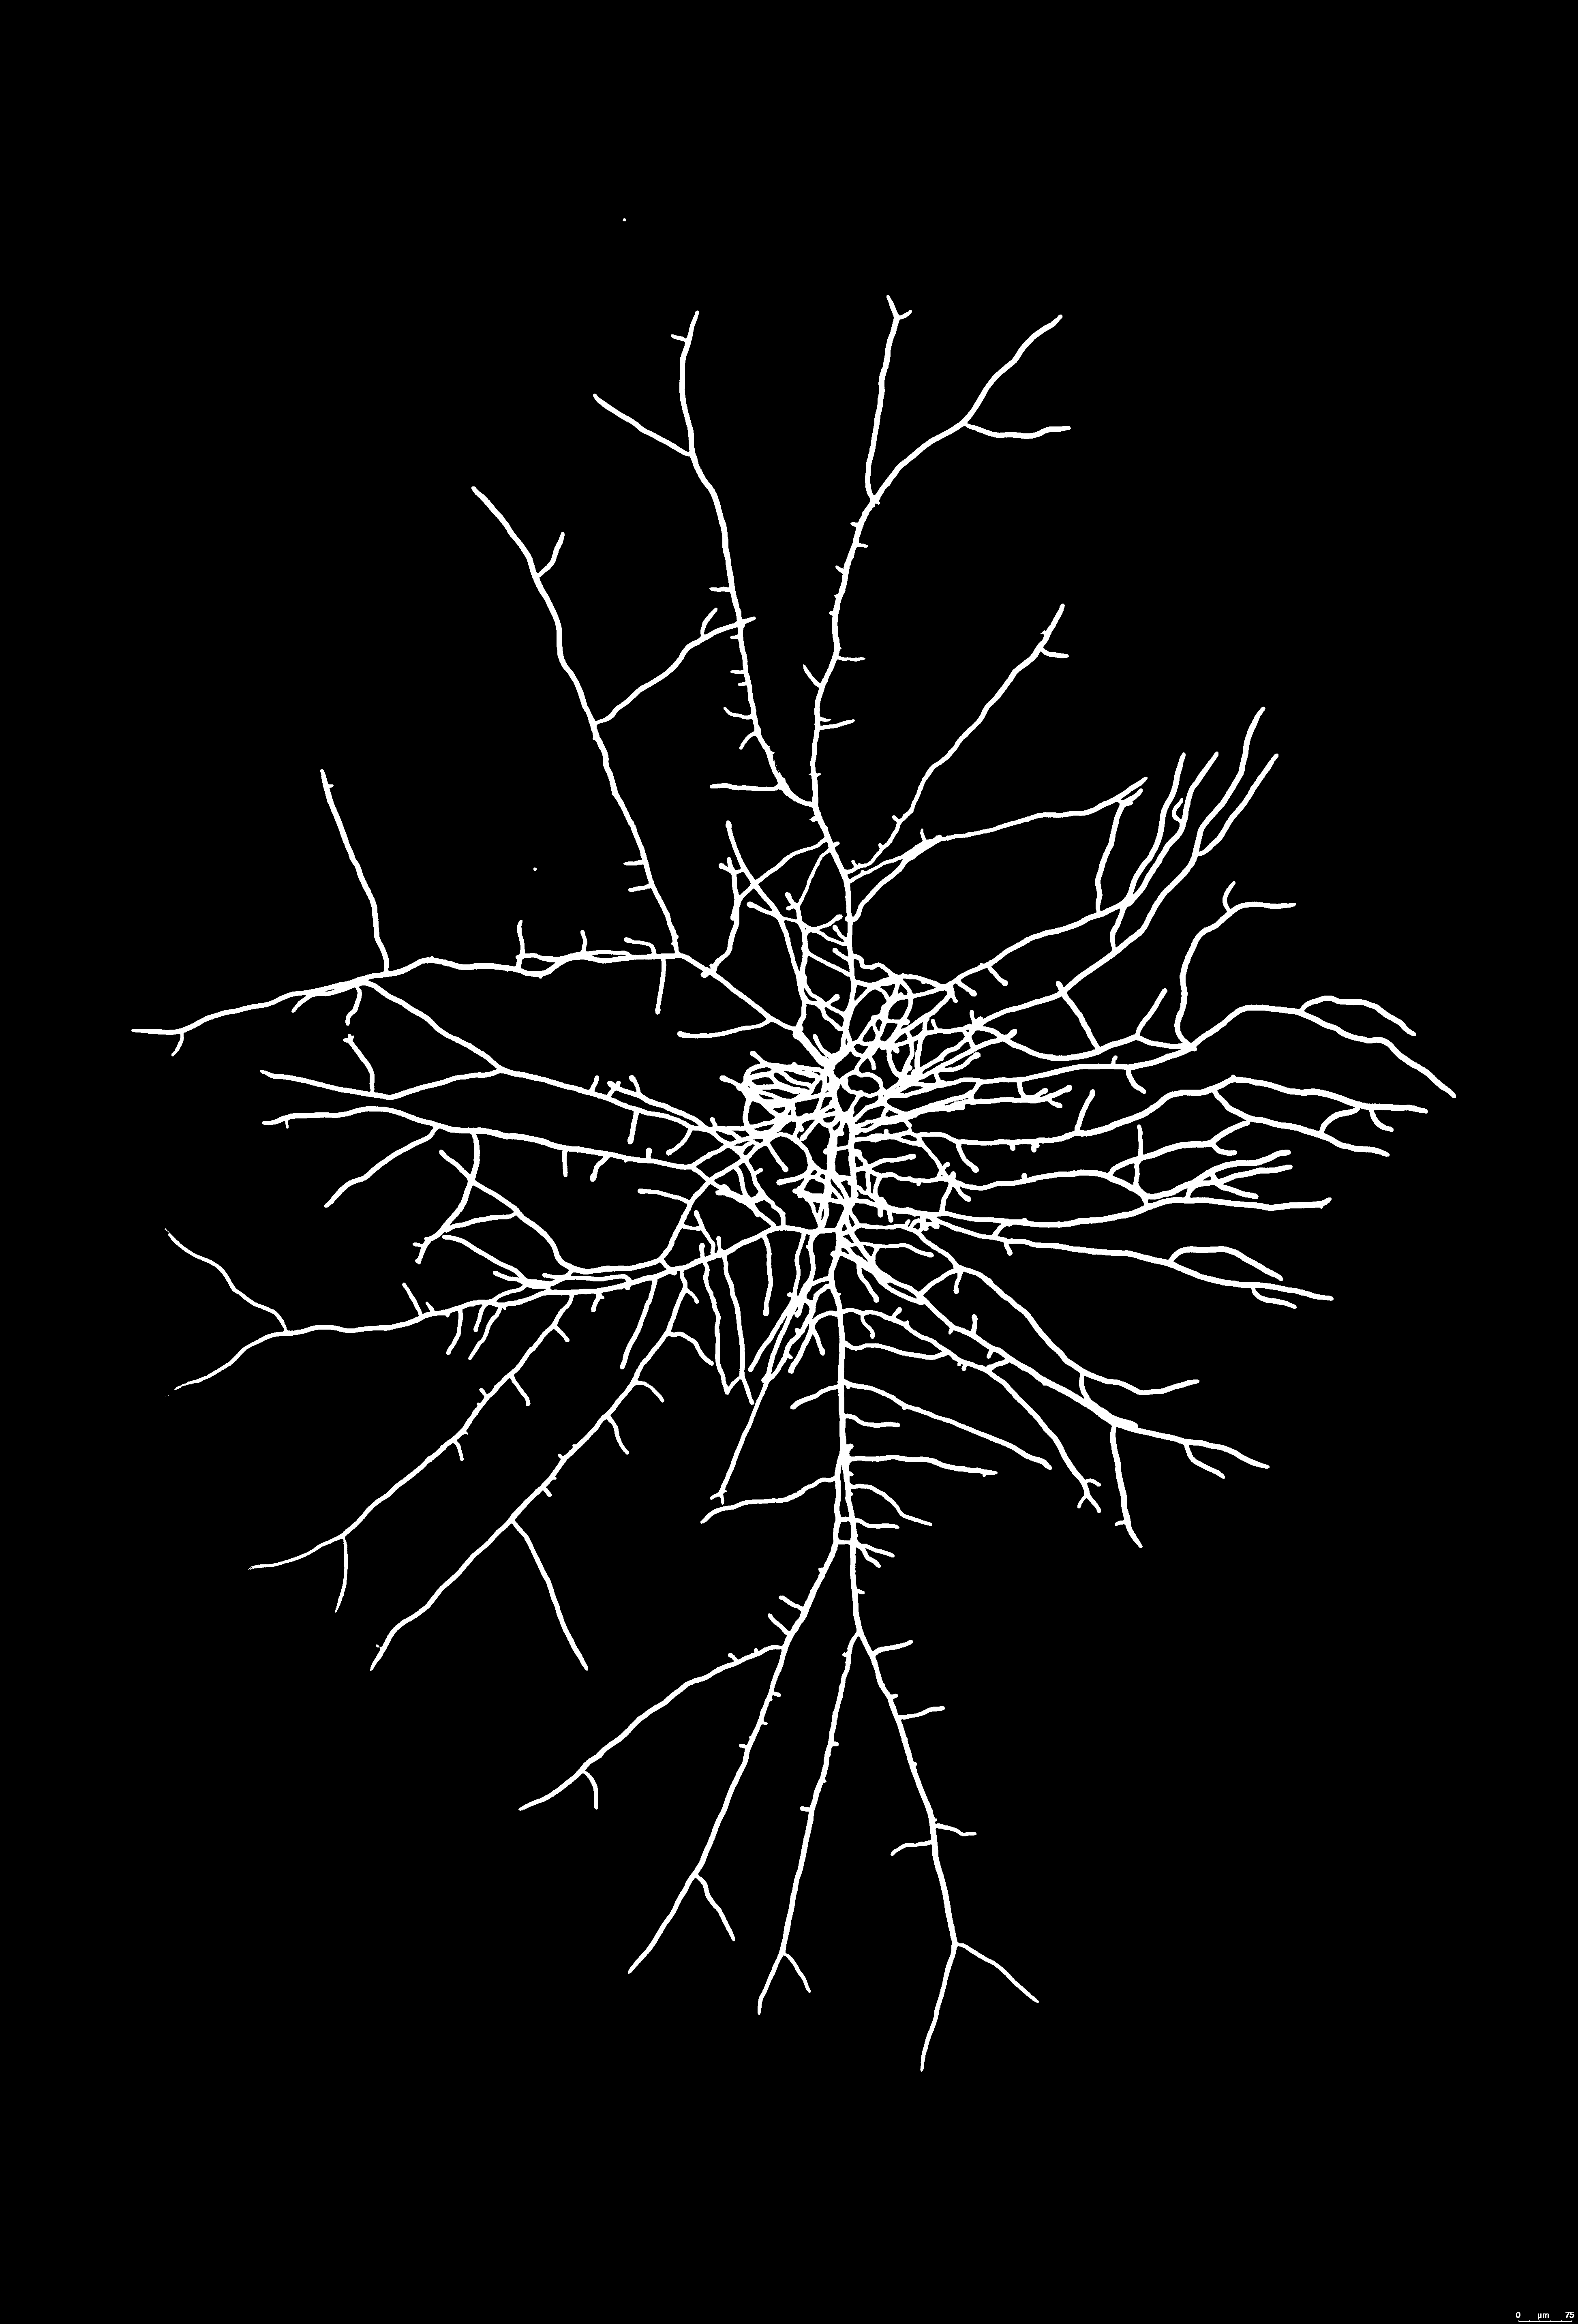

In [40]:
img_binarized = img_gray.copy()
img_binarized[img_binarized >= 25] = 255
img_binarized[img_binarized < 25] = 0

#plt.figure(figsize=[15,15])
#plt.imshow(img_binarized)

img_binarized = Image.fromarray(img_binarized).convert("1")
img_binarized

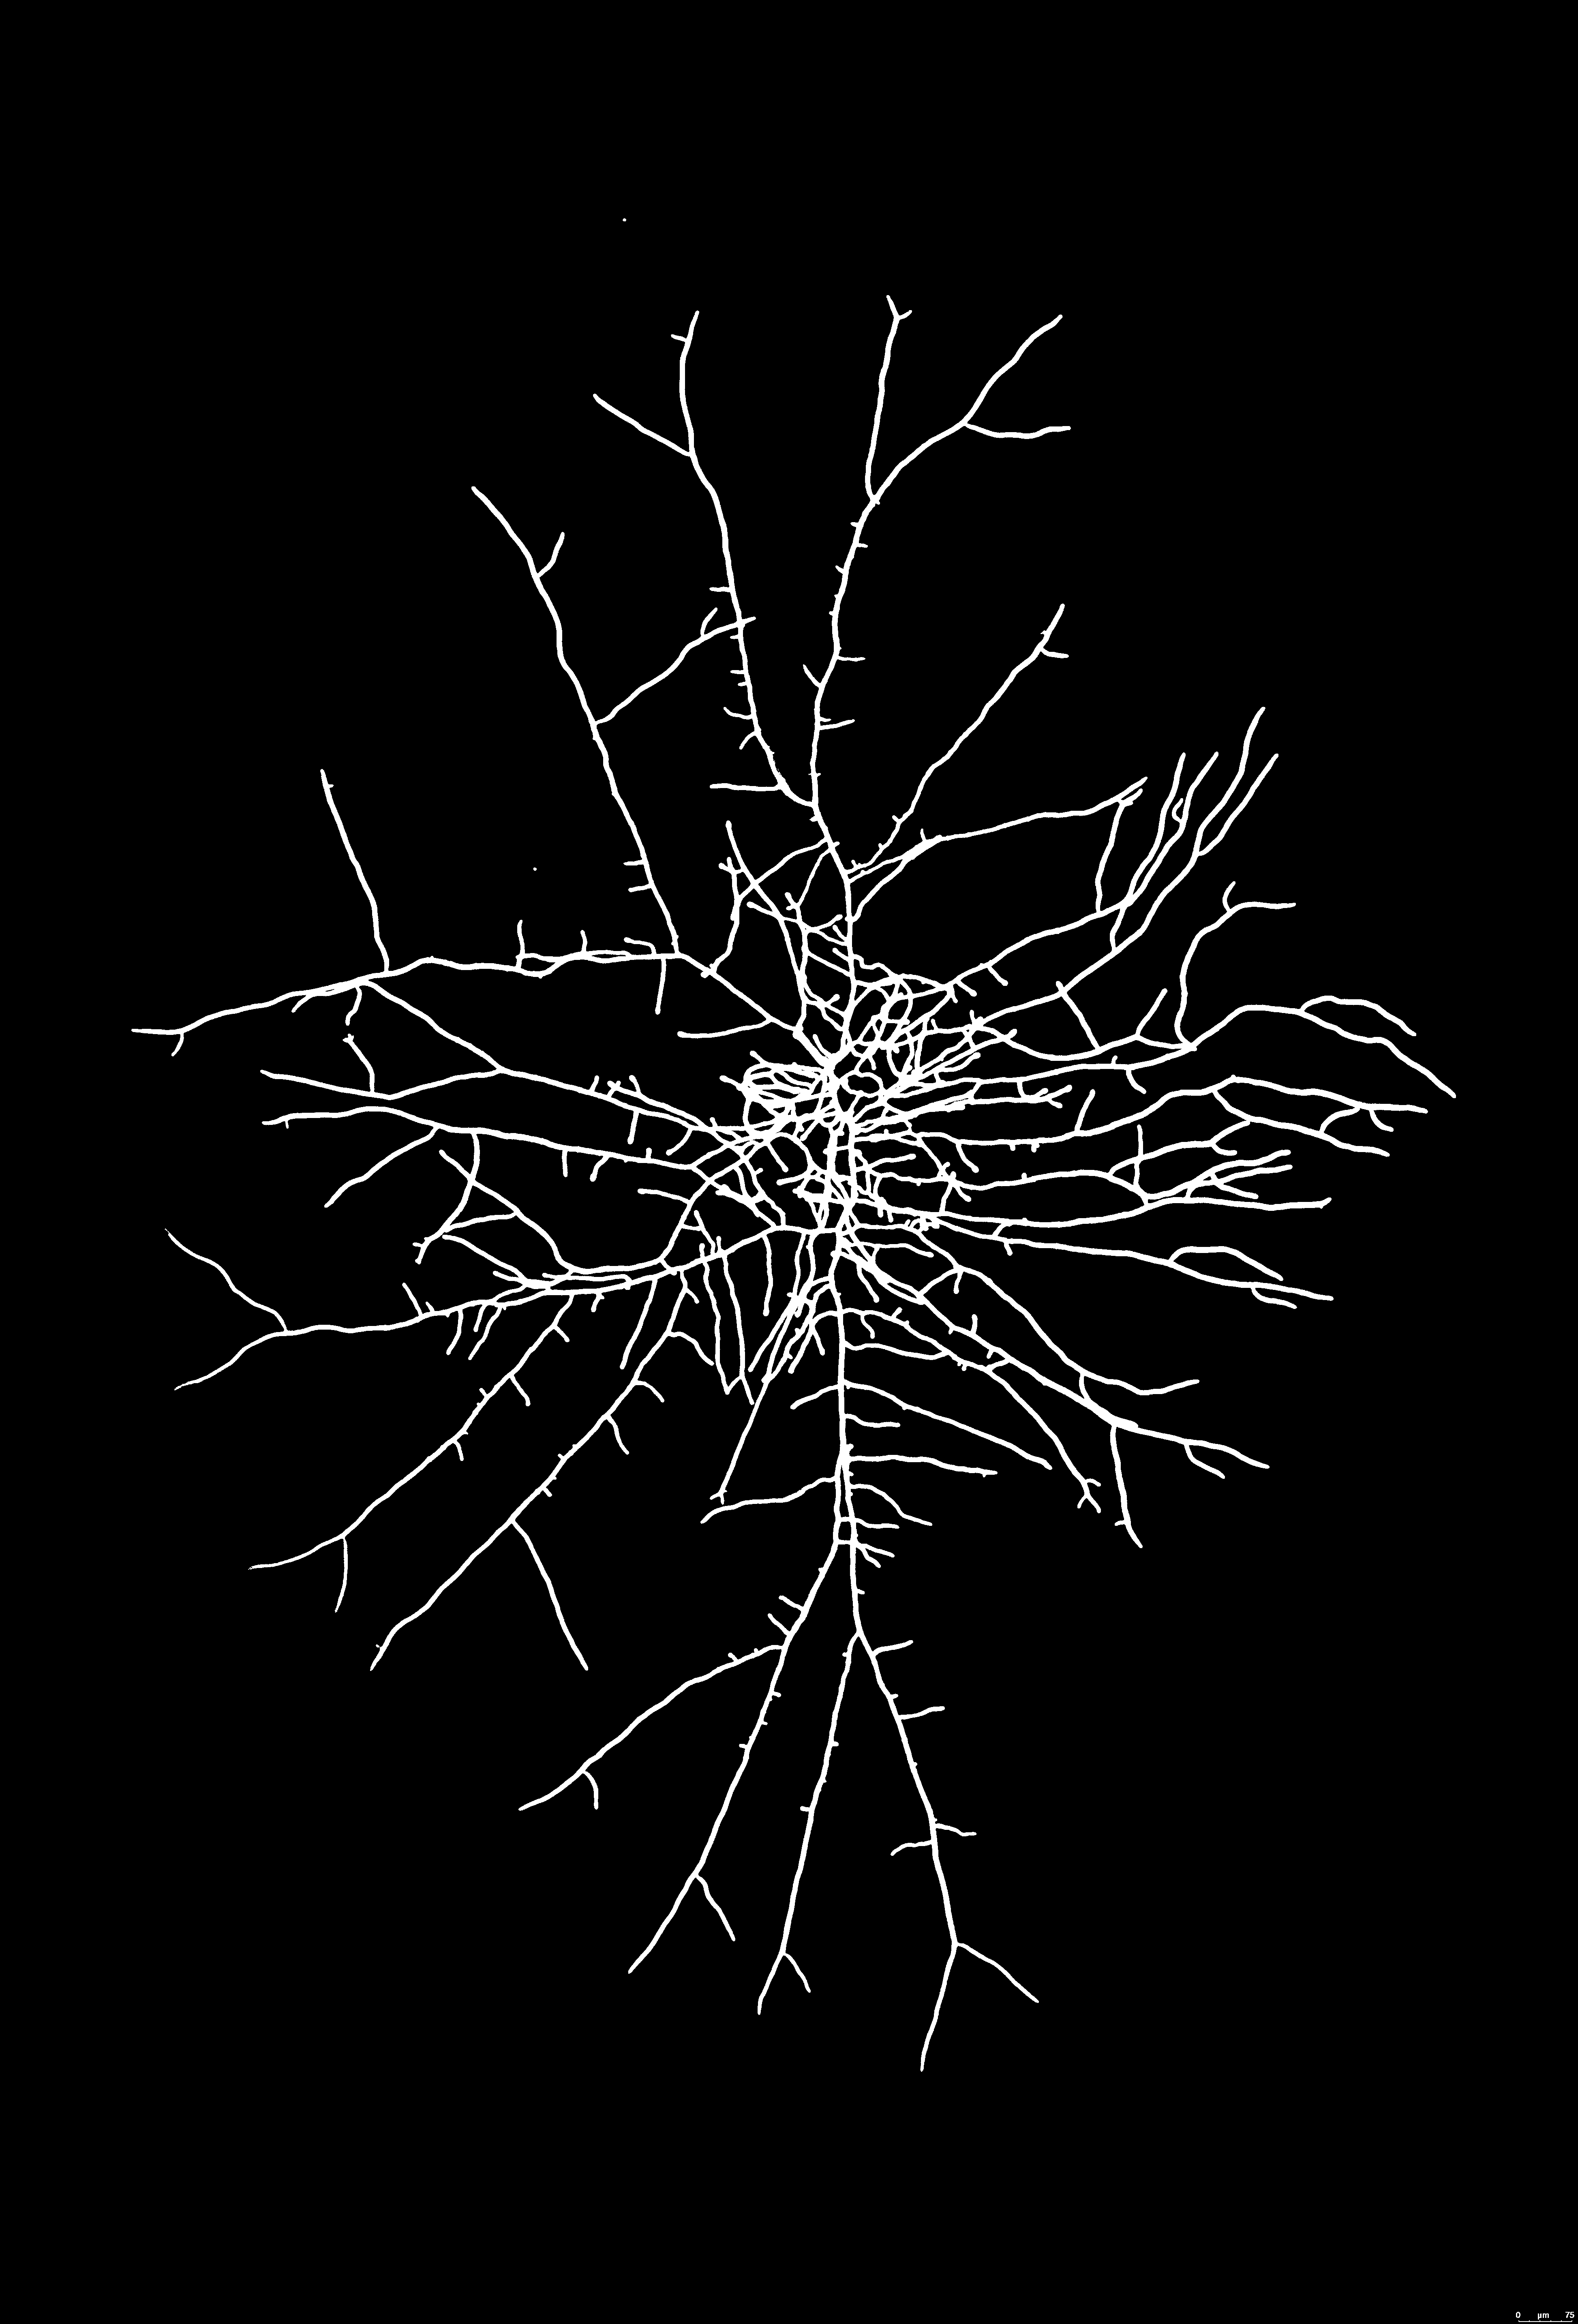

In [12]:
clean_binary_img = morphology.remove_small_objects(np.array(img_binarized), min_size=5)

img_open = Image.fromarray(clean_binary_img).convert("1")
img_open

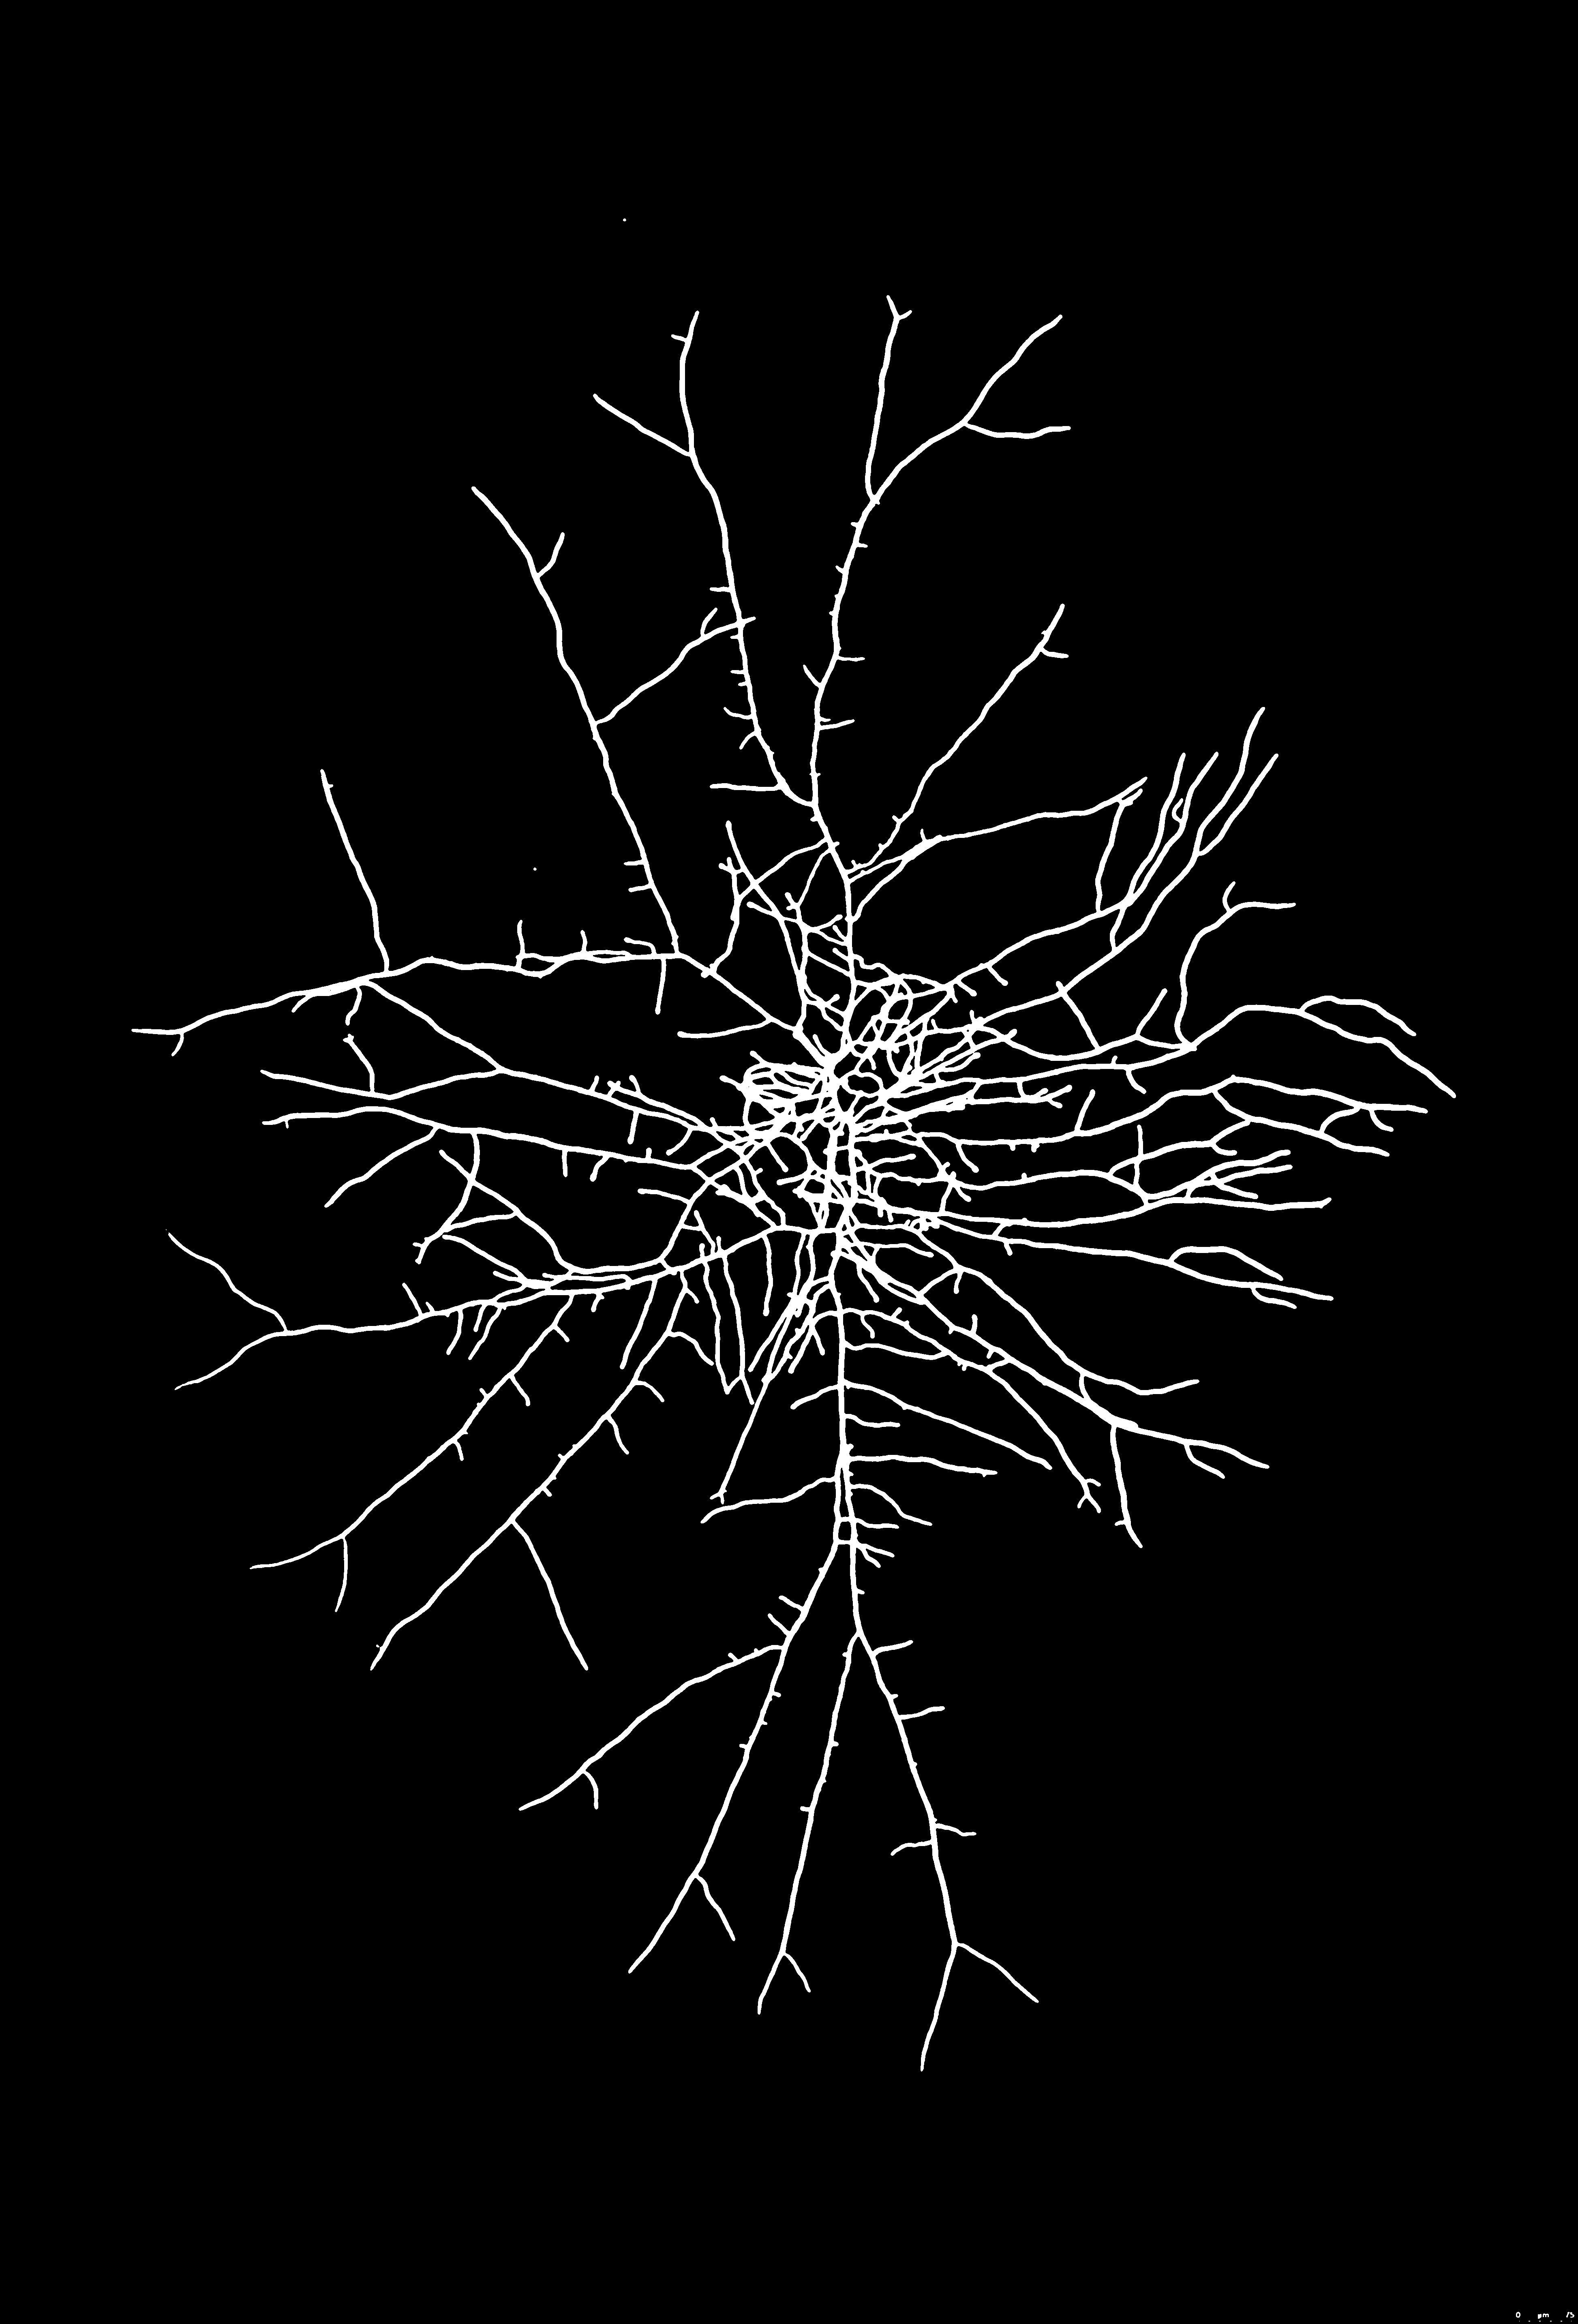

In [13]:
dilated_binary_img = filters.median(np.array(clean_binary_img), selem=morphology.square(5))
#dilated_binary_img = morphology.binary_erosion(np.array(clean_binary_img), selem=morphology.square(3))

img_open = Image.fromarray(dilated_binary_img).convert("1")
img_open

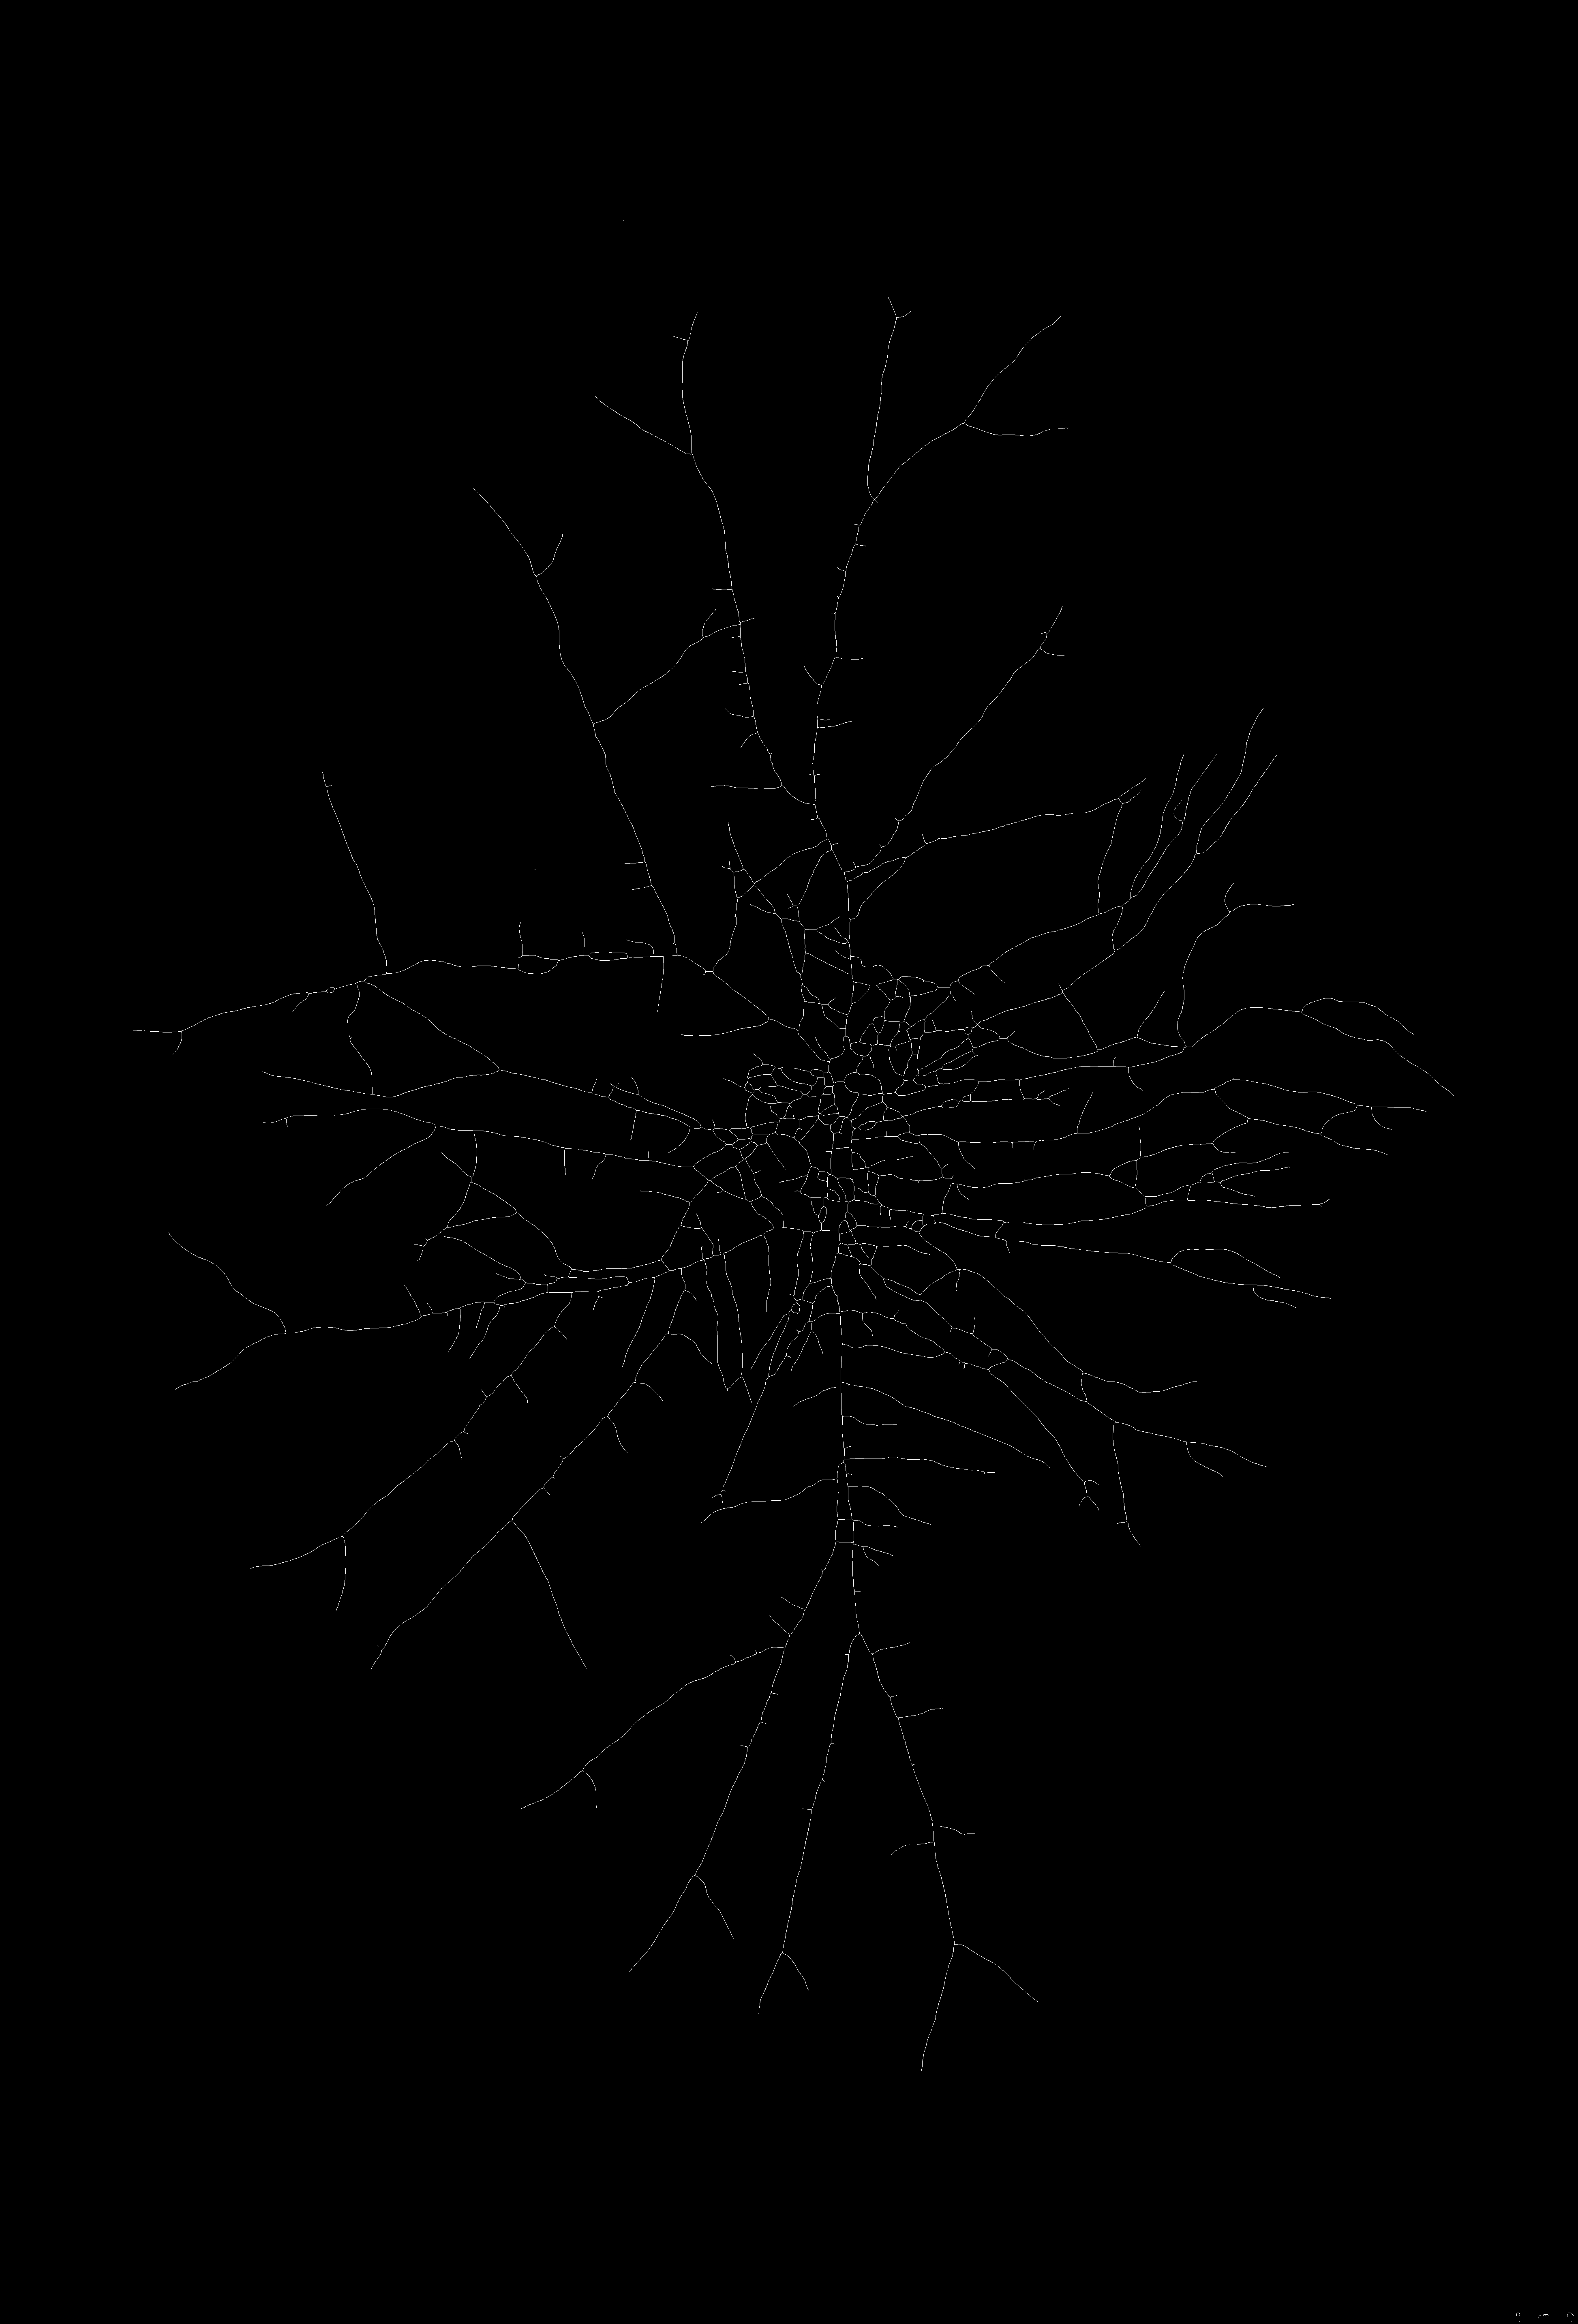

In [14]:
skeleton = morphology.skeletonize(dilated_binary_img)

#plt.figure(figsize=[15,15])
#plt.imshow(skeleton[500:700, 550:750])

img_open = Image.fromarray(skeleton).convert("1")
img_open

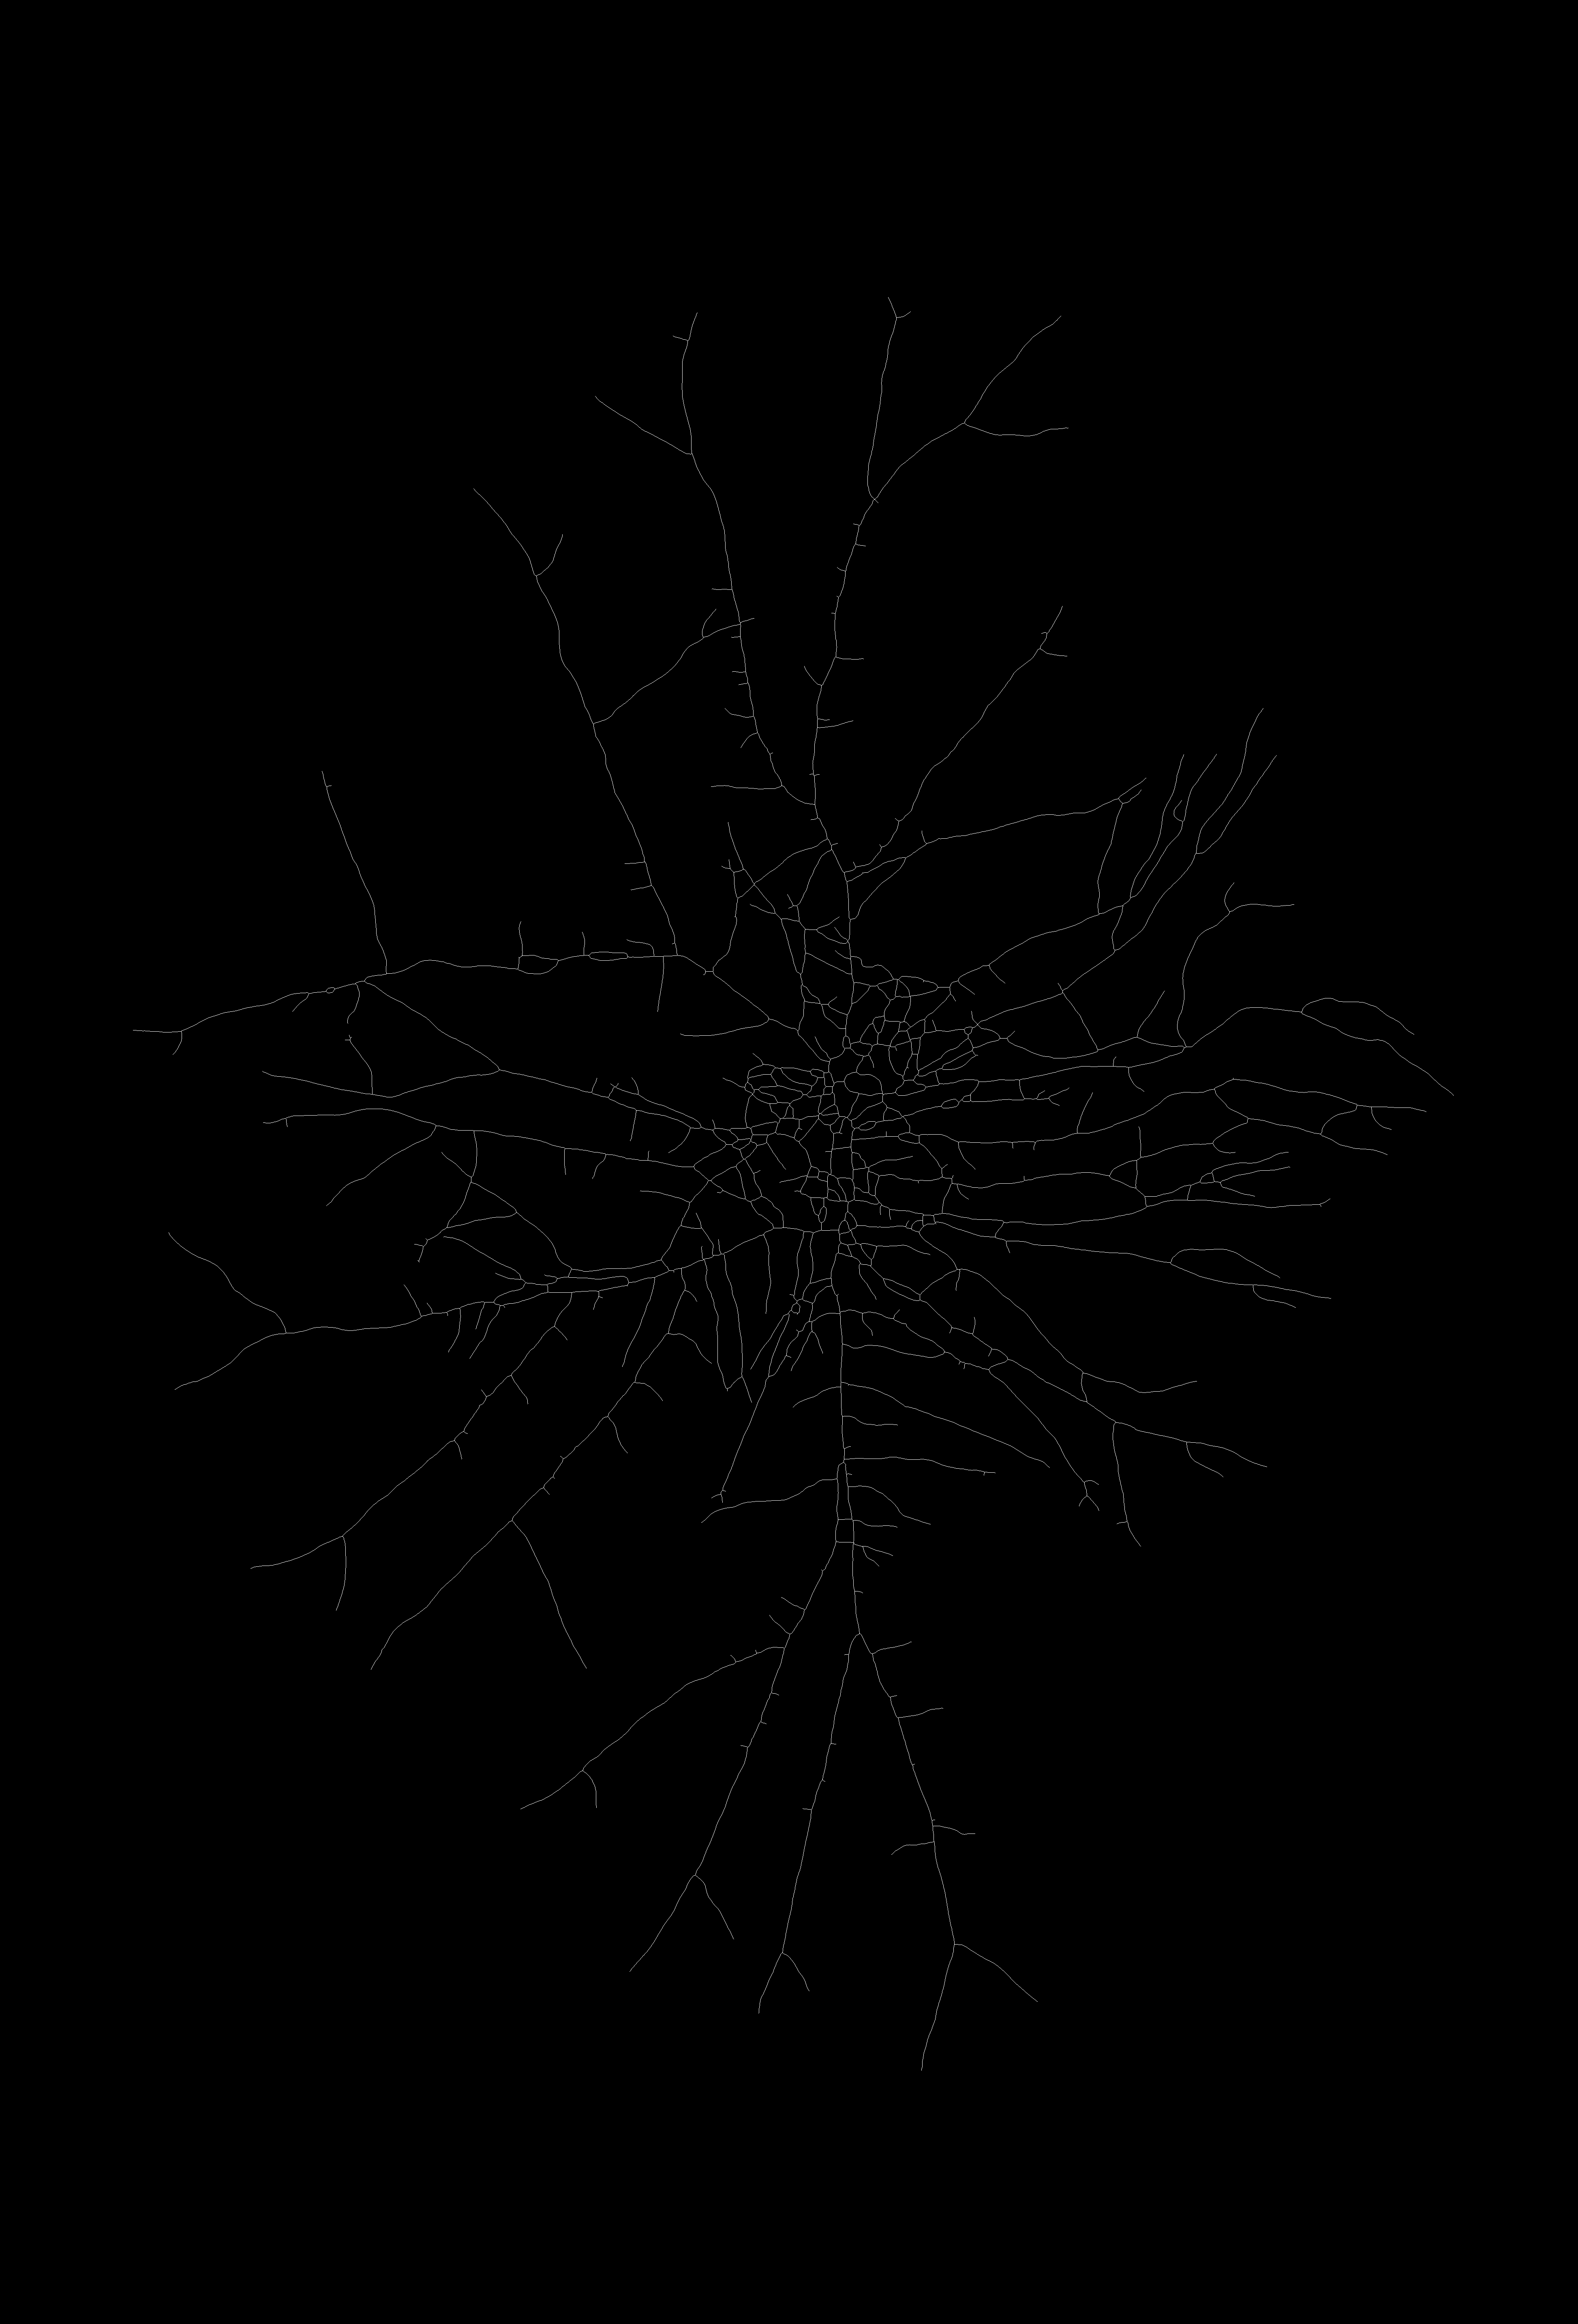

In [16]:
clean_skeleton = morphology.remove_small_objects(np.array(skeleton), min_size=100, connectivity=2)

img_open = Image.fromarray(clean_skeleton).convert("1")
img_open

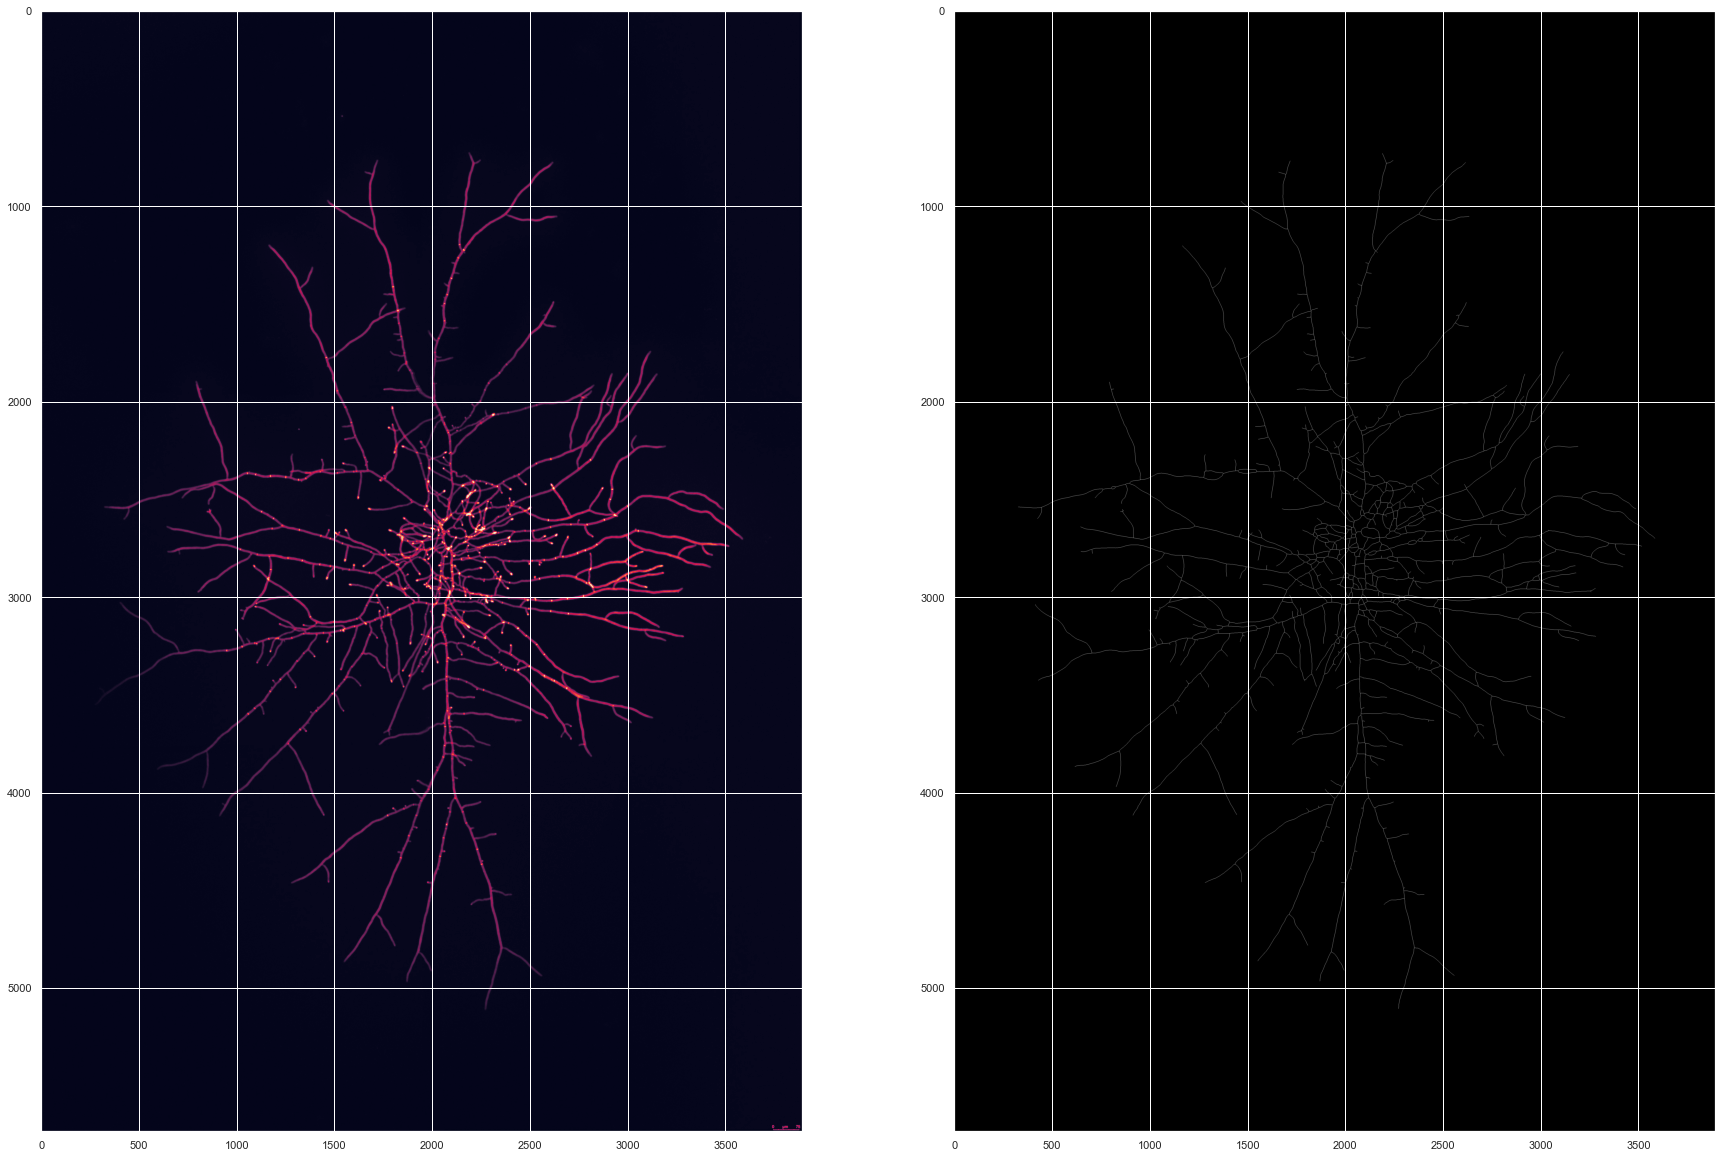

In [17]:
f, ax = plt.subplots(1,2, figsize=[30,30])
ax[0].imshow(img_gray)
ax[1].imshow(img_open)

In [18]:
padded_skeleton = np.pad(clean_skeleton, (2, 2), 'constant', constant_values=False)

h, w = padded_skeleton.shape

branches = np.full([h,w], False, dtype=bool)
tips = np.full([h,w], False, dtype=bool)

In [19]:
coords = np.argwhere(padded_skeleton)

In [20]:
for i in coords:
    x, y = i[0], i[1]
    neighbourhood = np.array(padded_skeleton[x-1:x+2, y-1:y+2])
    branch_neighbourhood = np.array(branches[x-3:x+4, y-3:y+4])
    if np.sum(neighbourhood) == 4 and np.sum(branch_neighbourhood) == 0:
        branches[x,y] = True
    elif np.sum(neighbourhood) == 2:
        tips[x,y] = True

In [21]:
np.sum(branches)

550

In [22]:
np.sum(tips)

269

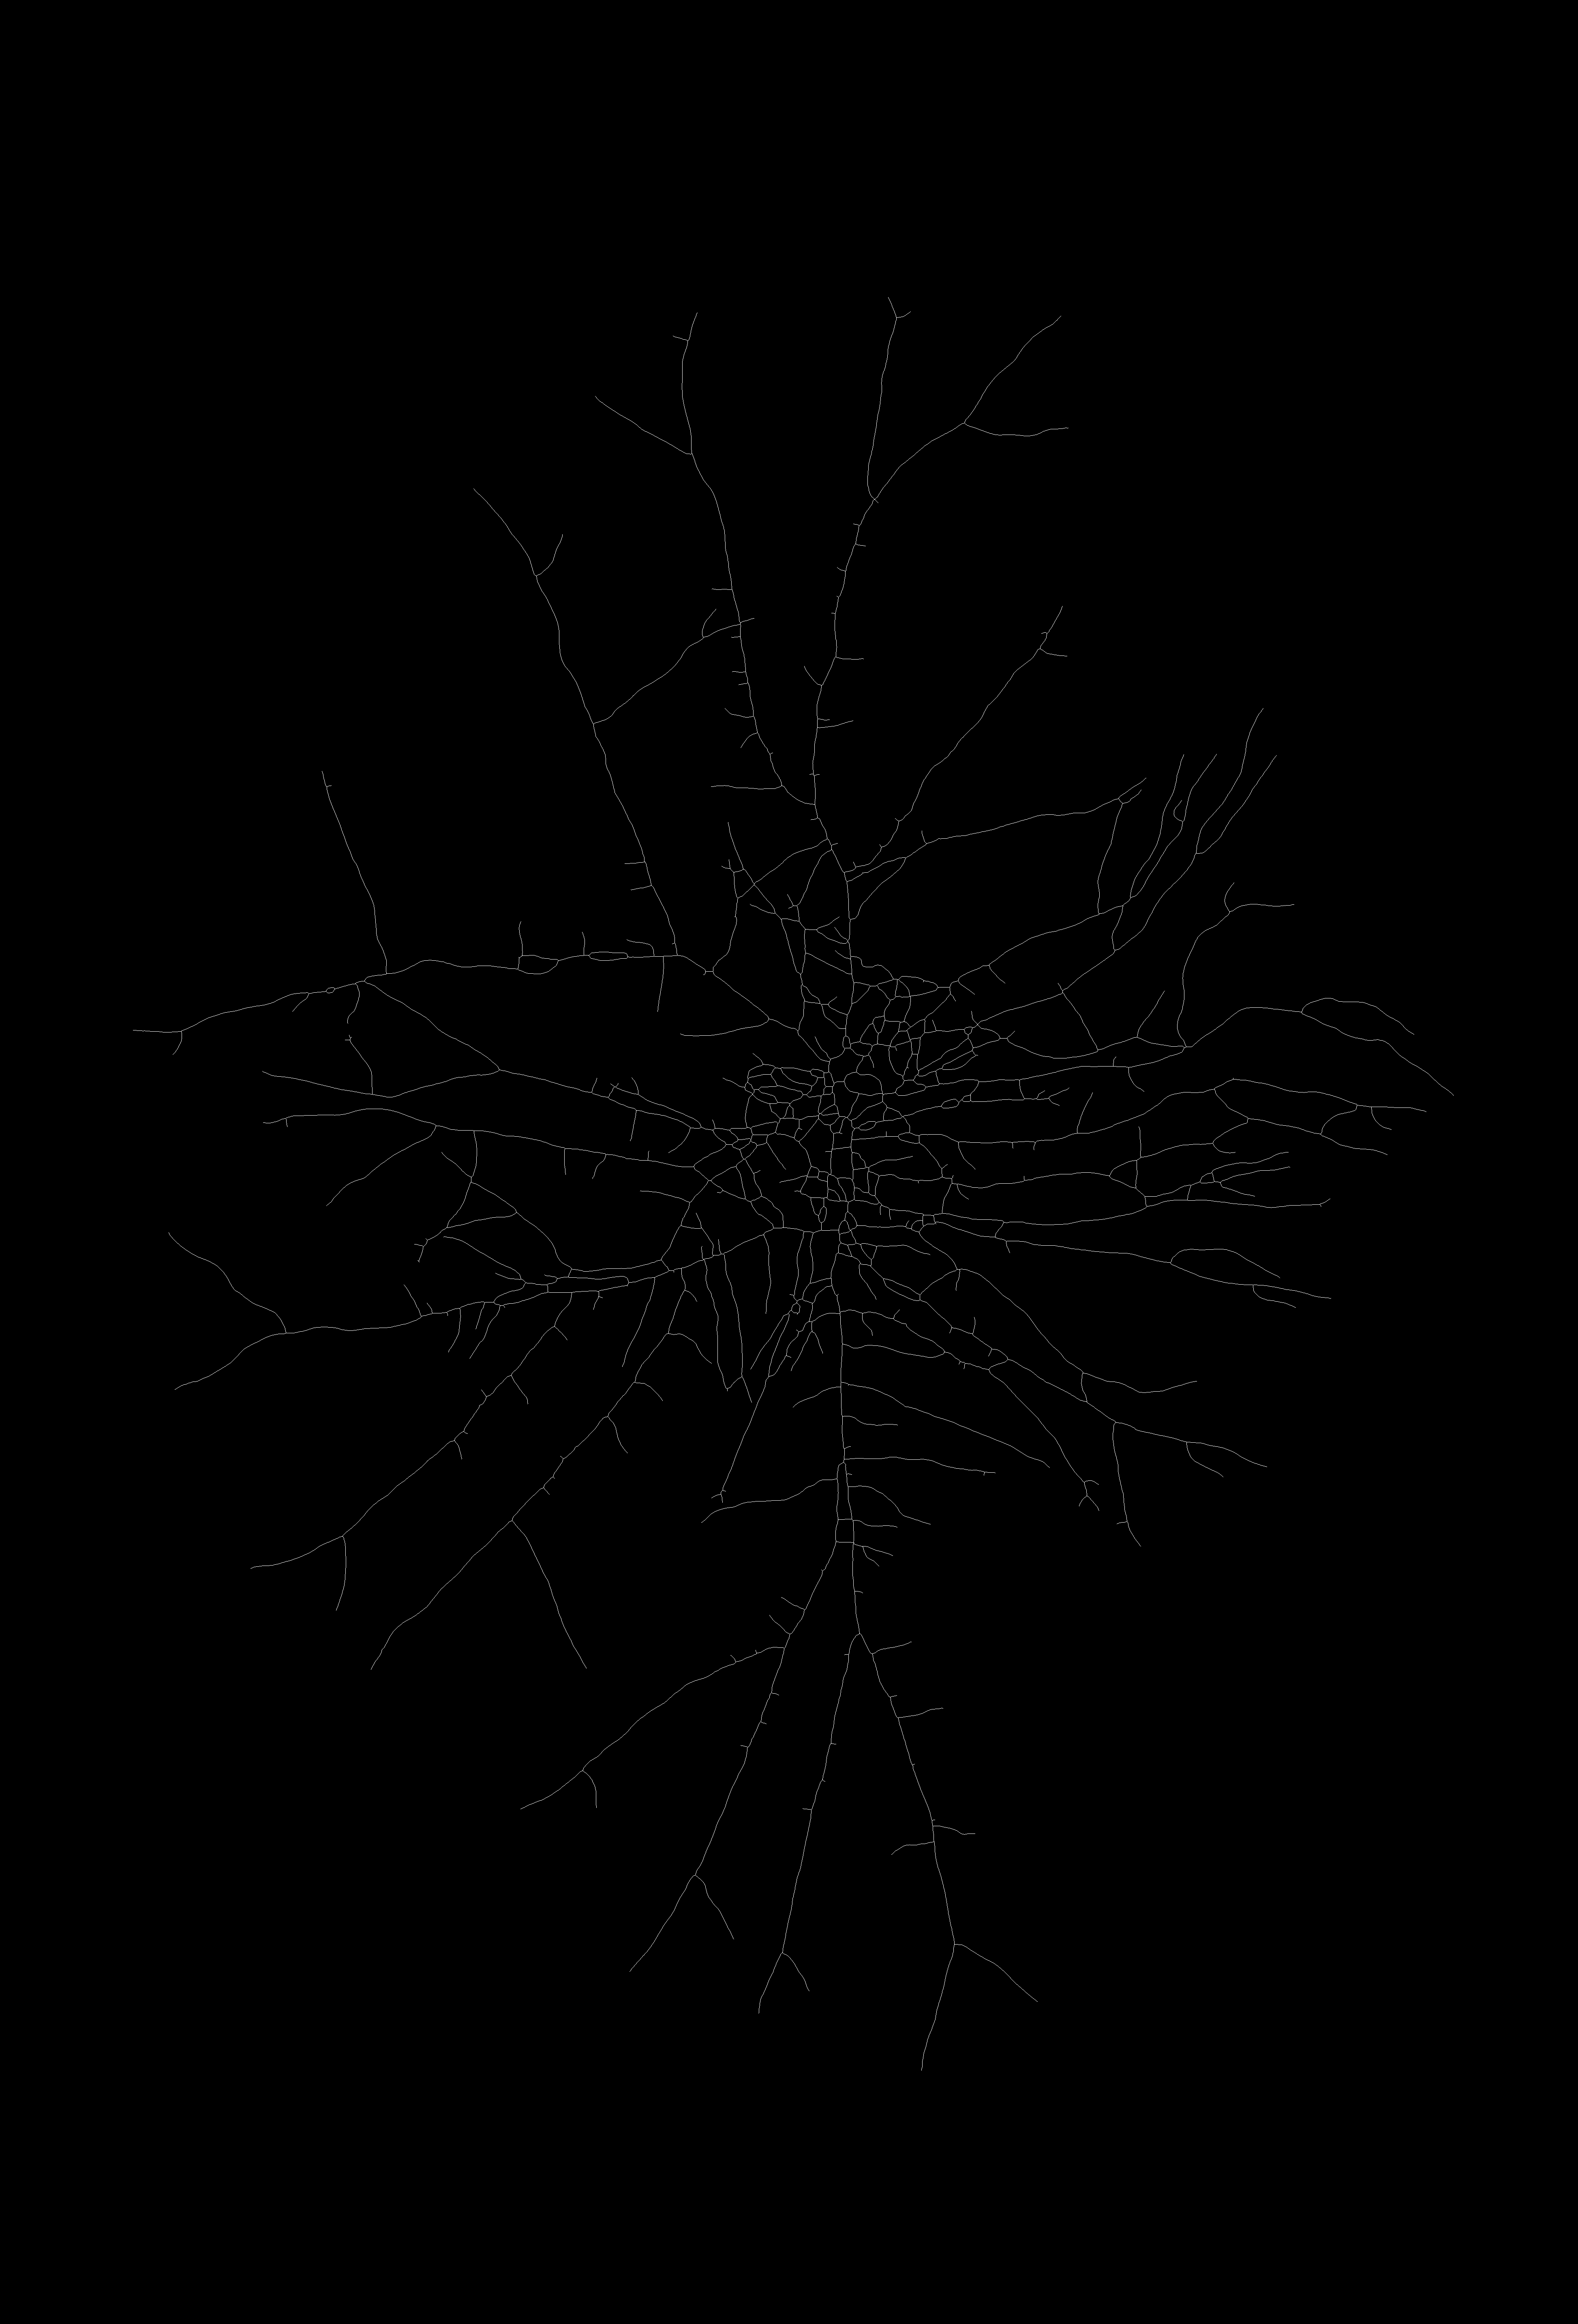

In [23]:
img_open

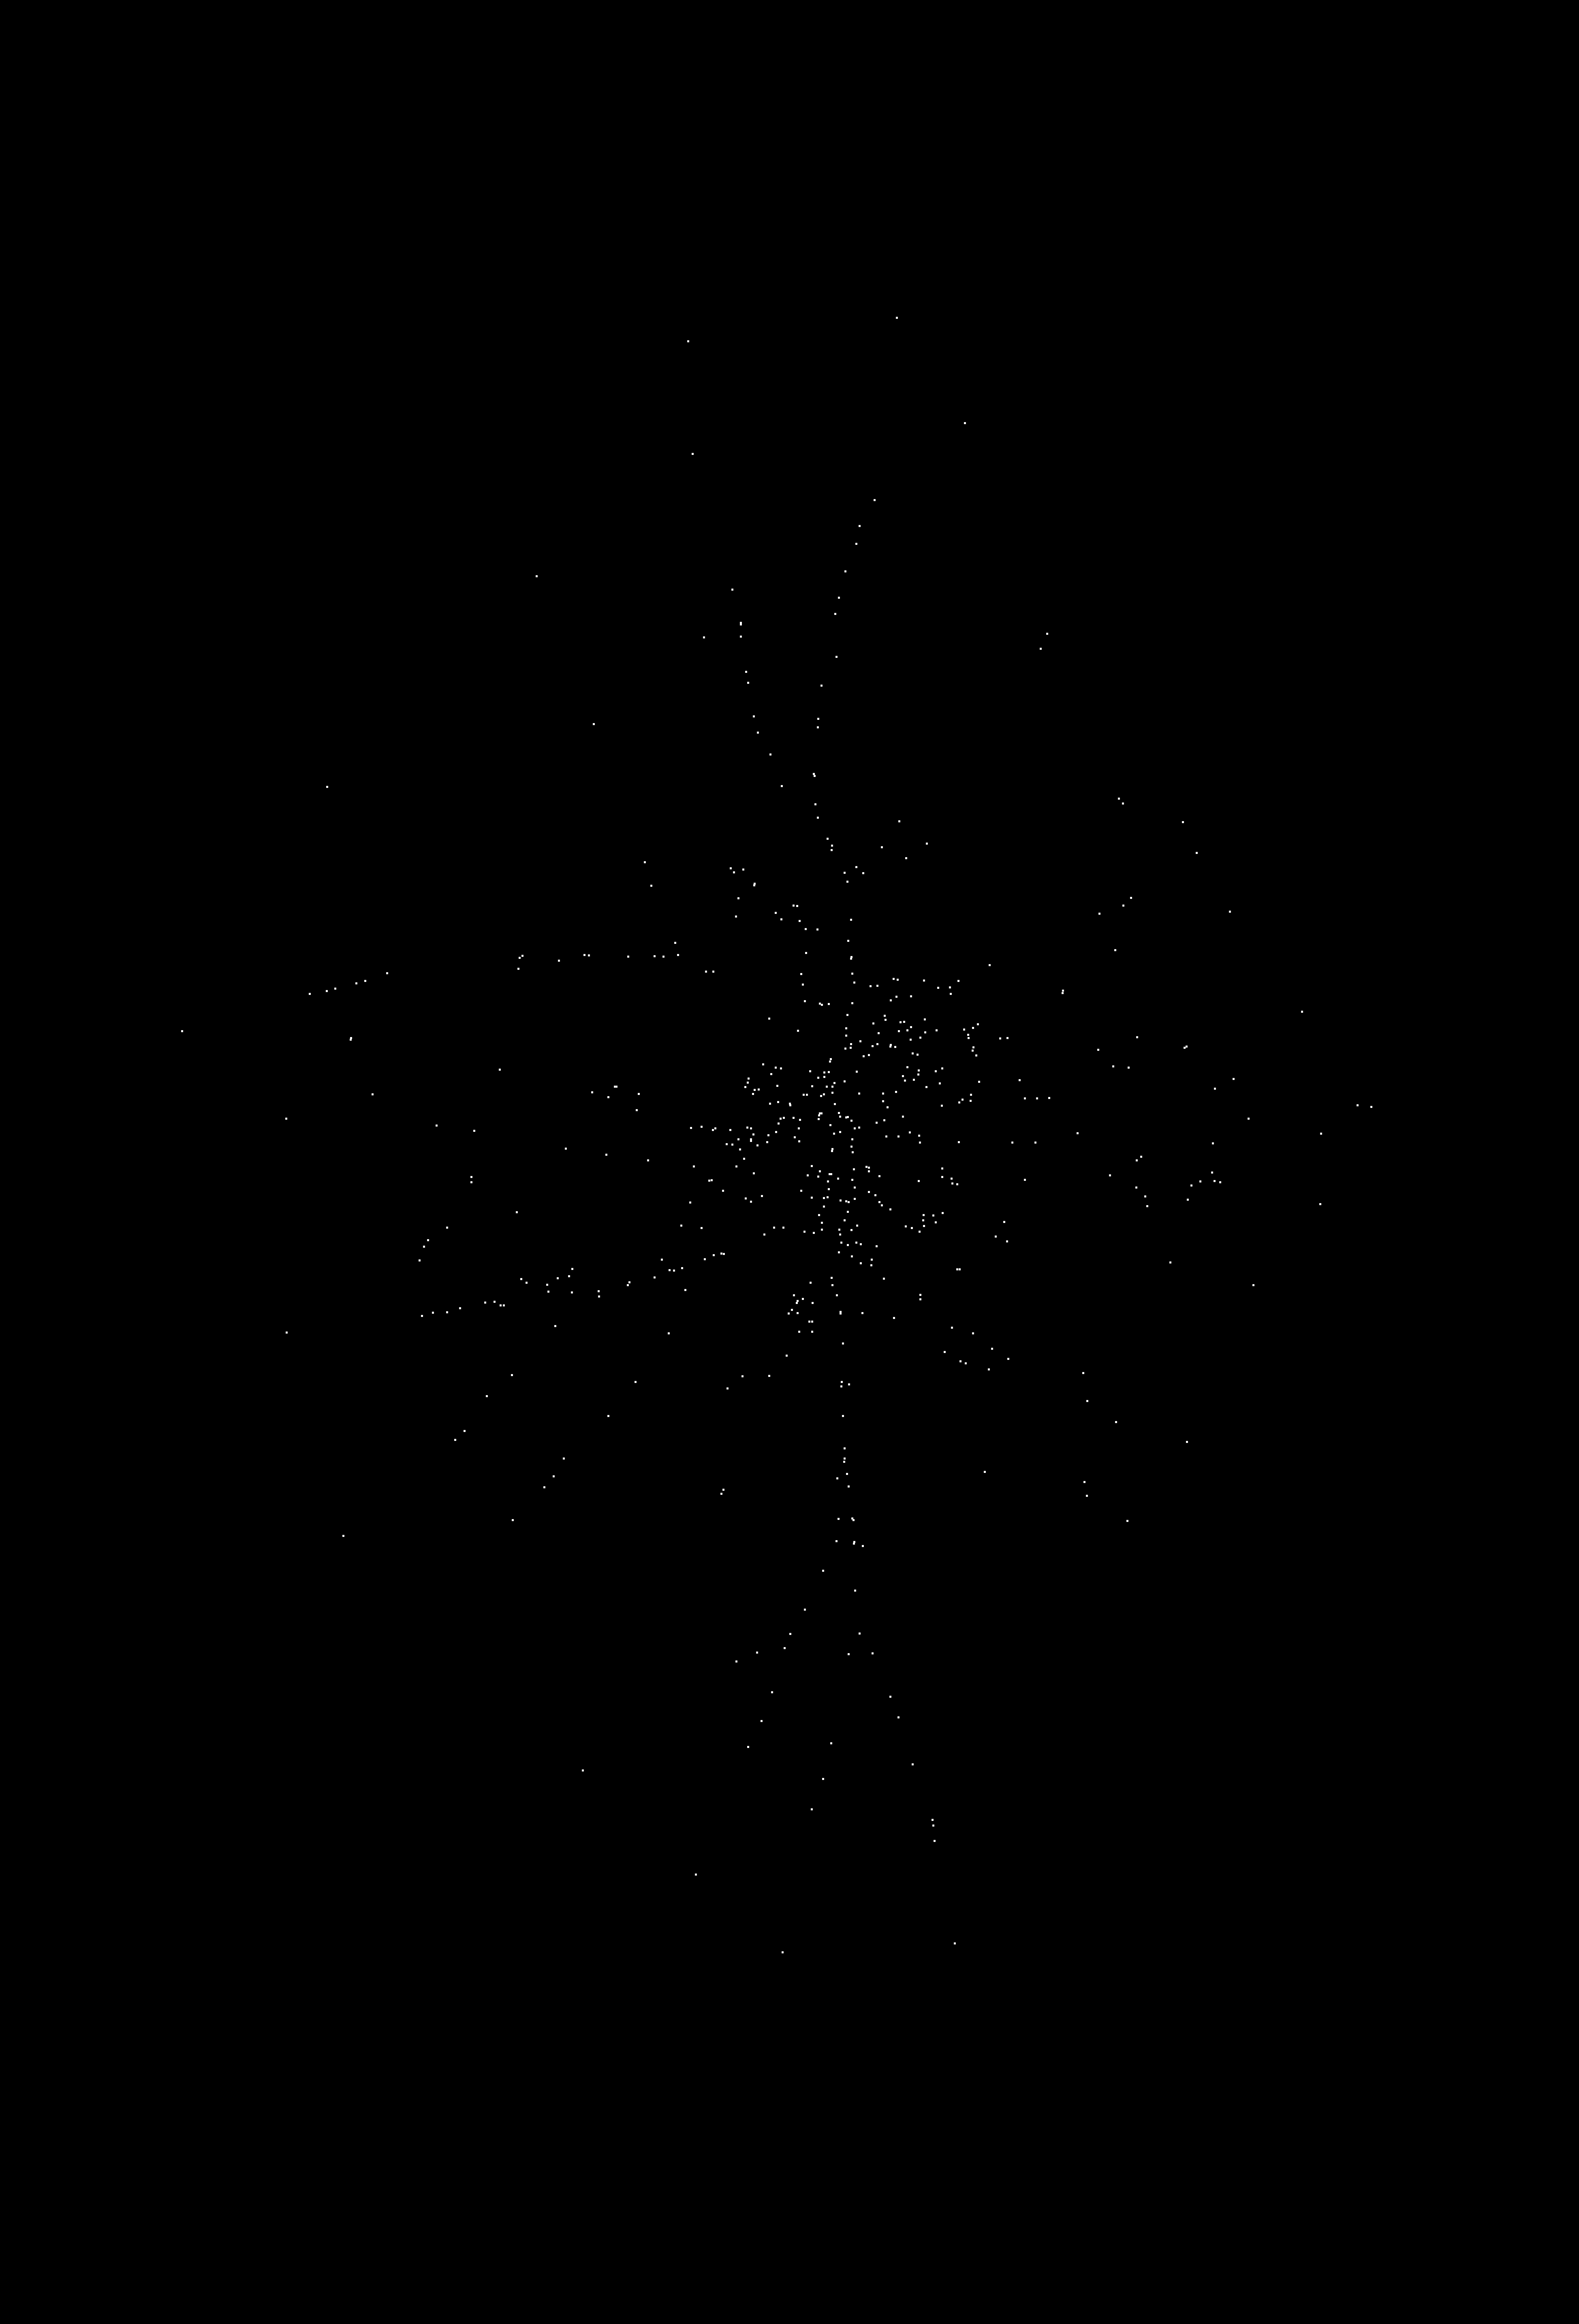

In [24]:
mark_branches = morphology.binary_dilation(branches, morphology.square(5))

Image.fromarray(mark_branches).convert("1")

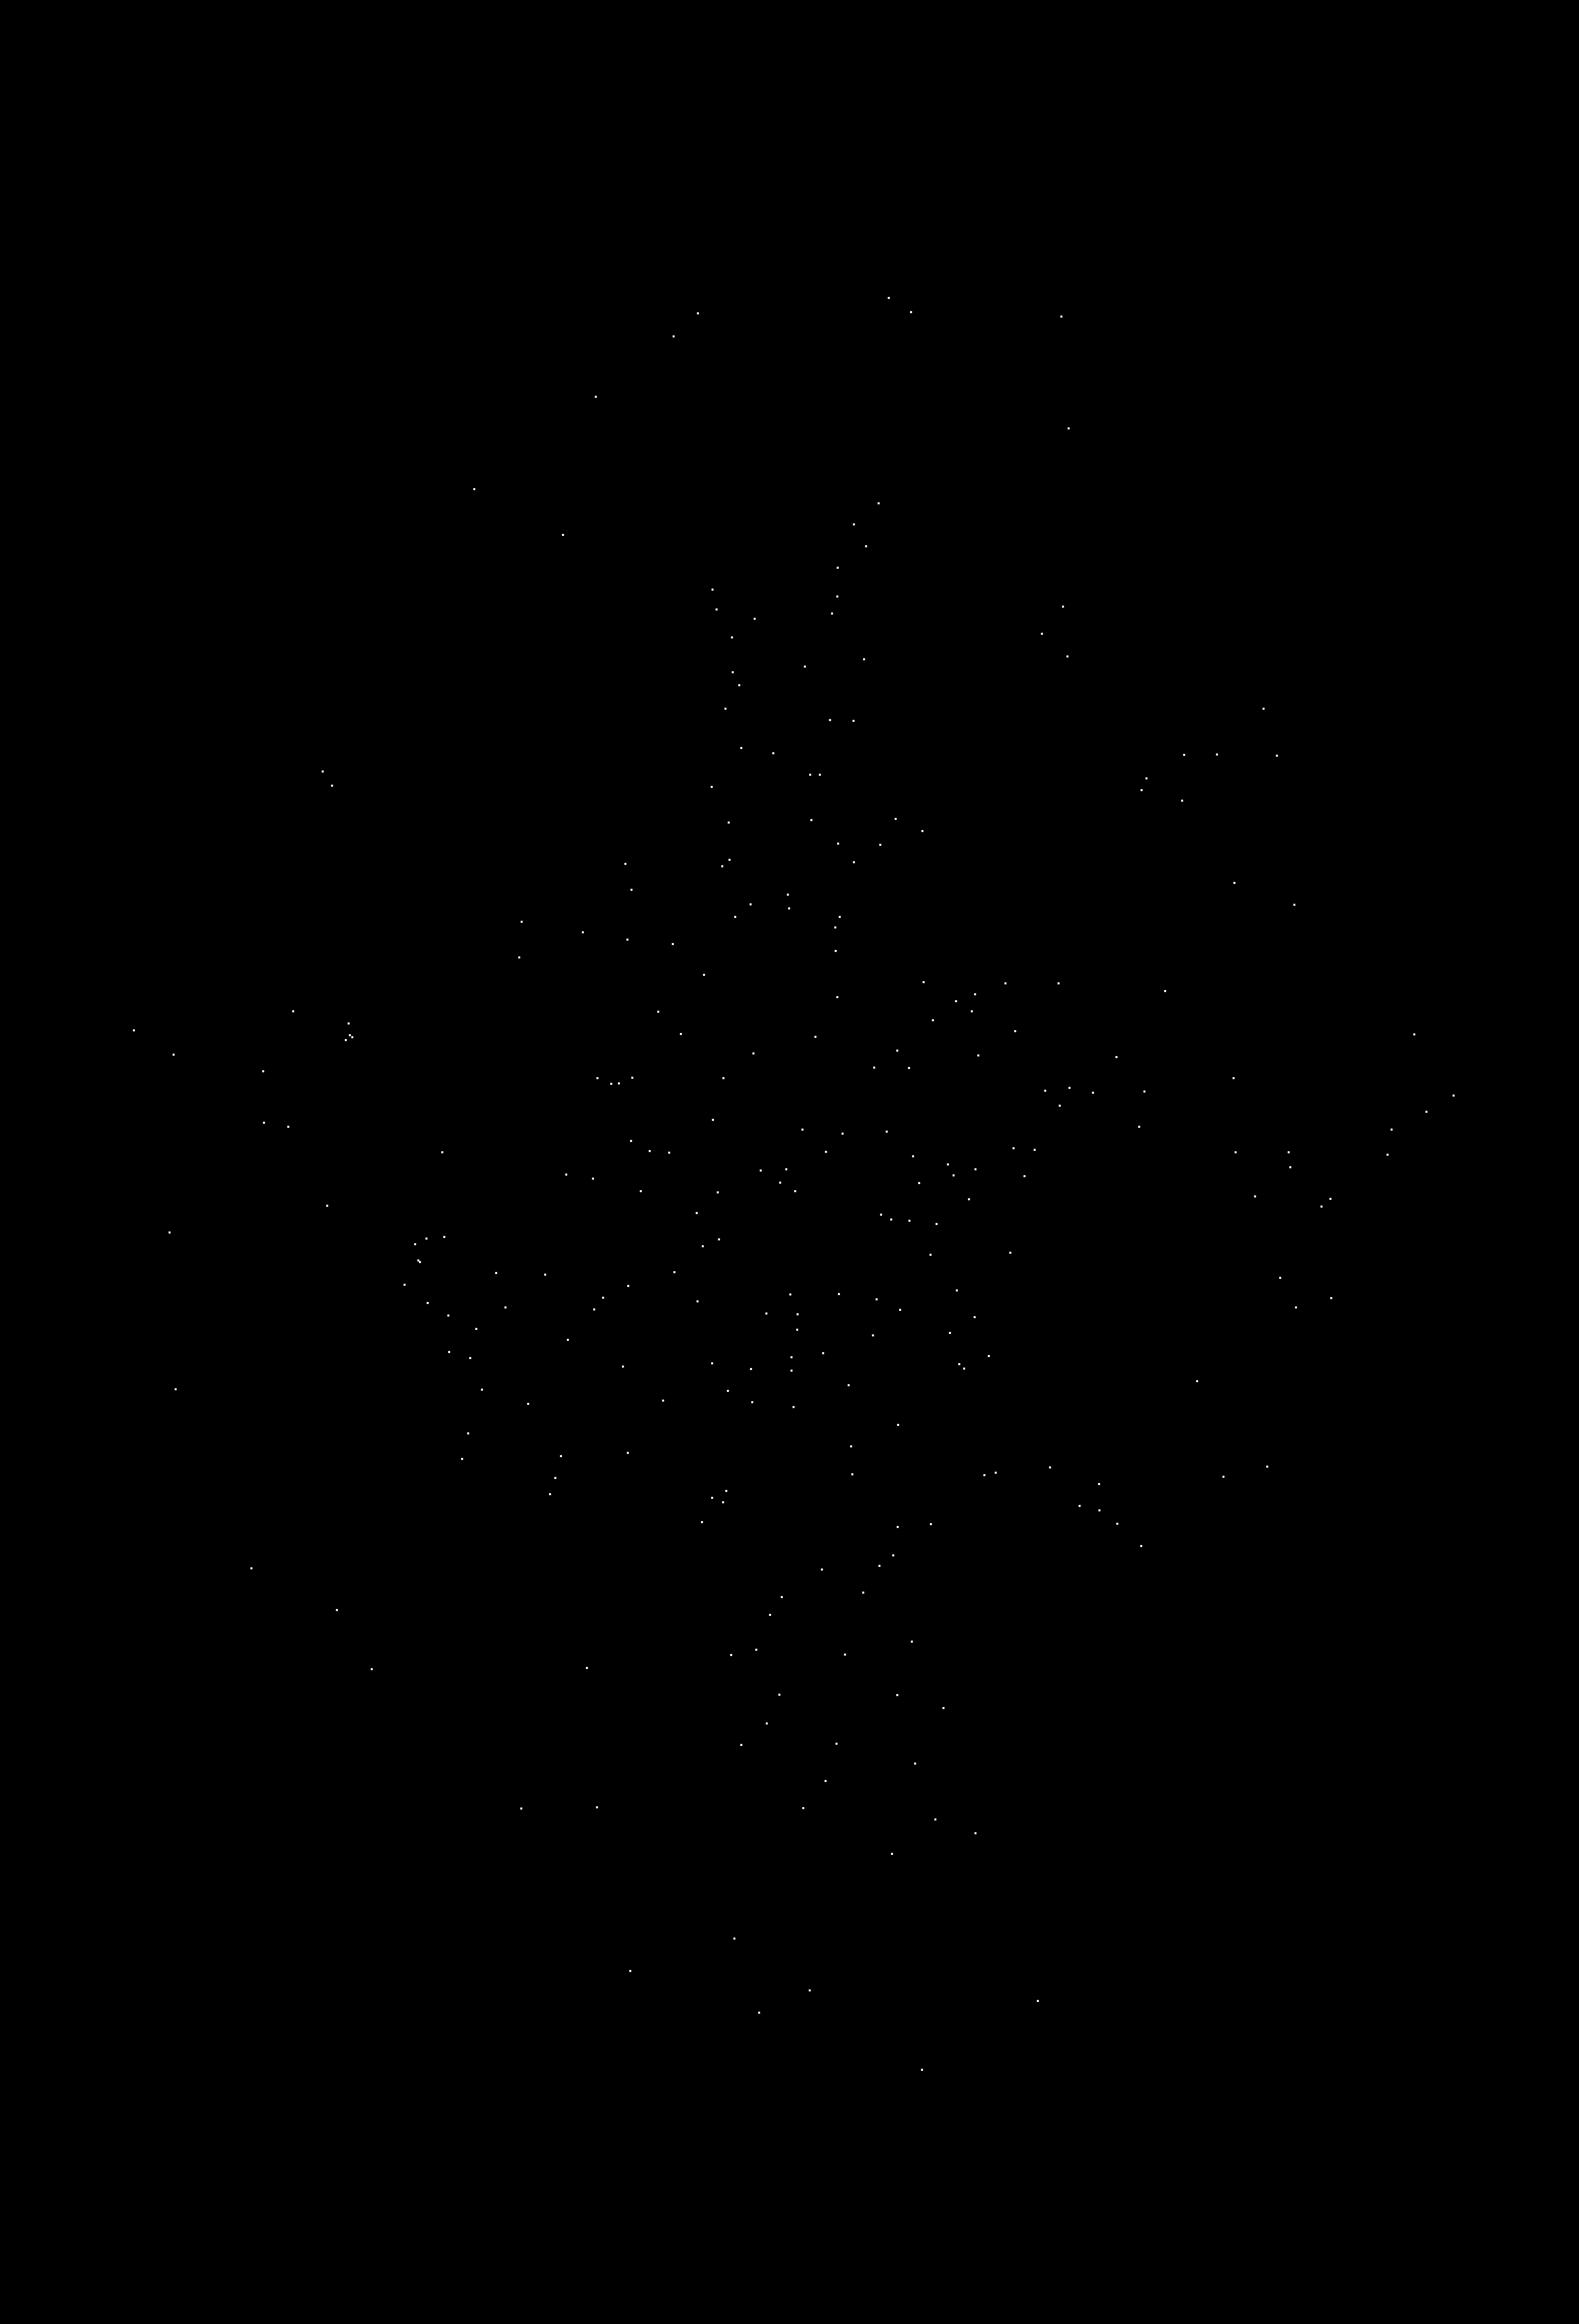

In [25]:
mark_tips = morphology.binary_dilation(tips, morphology.square(5))

Image.fromarray(mark_tips).convert("1")

In [26]:
pad_img_gray = np.pad(img_gray, (2, 2), 'constant', constant_values=0)

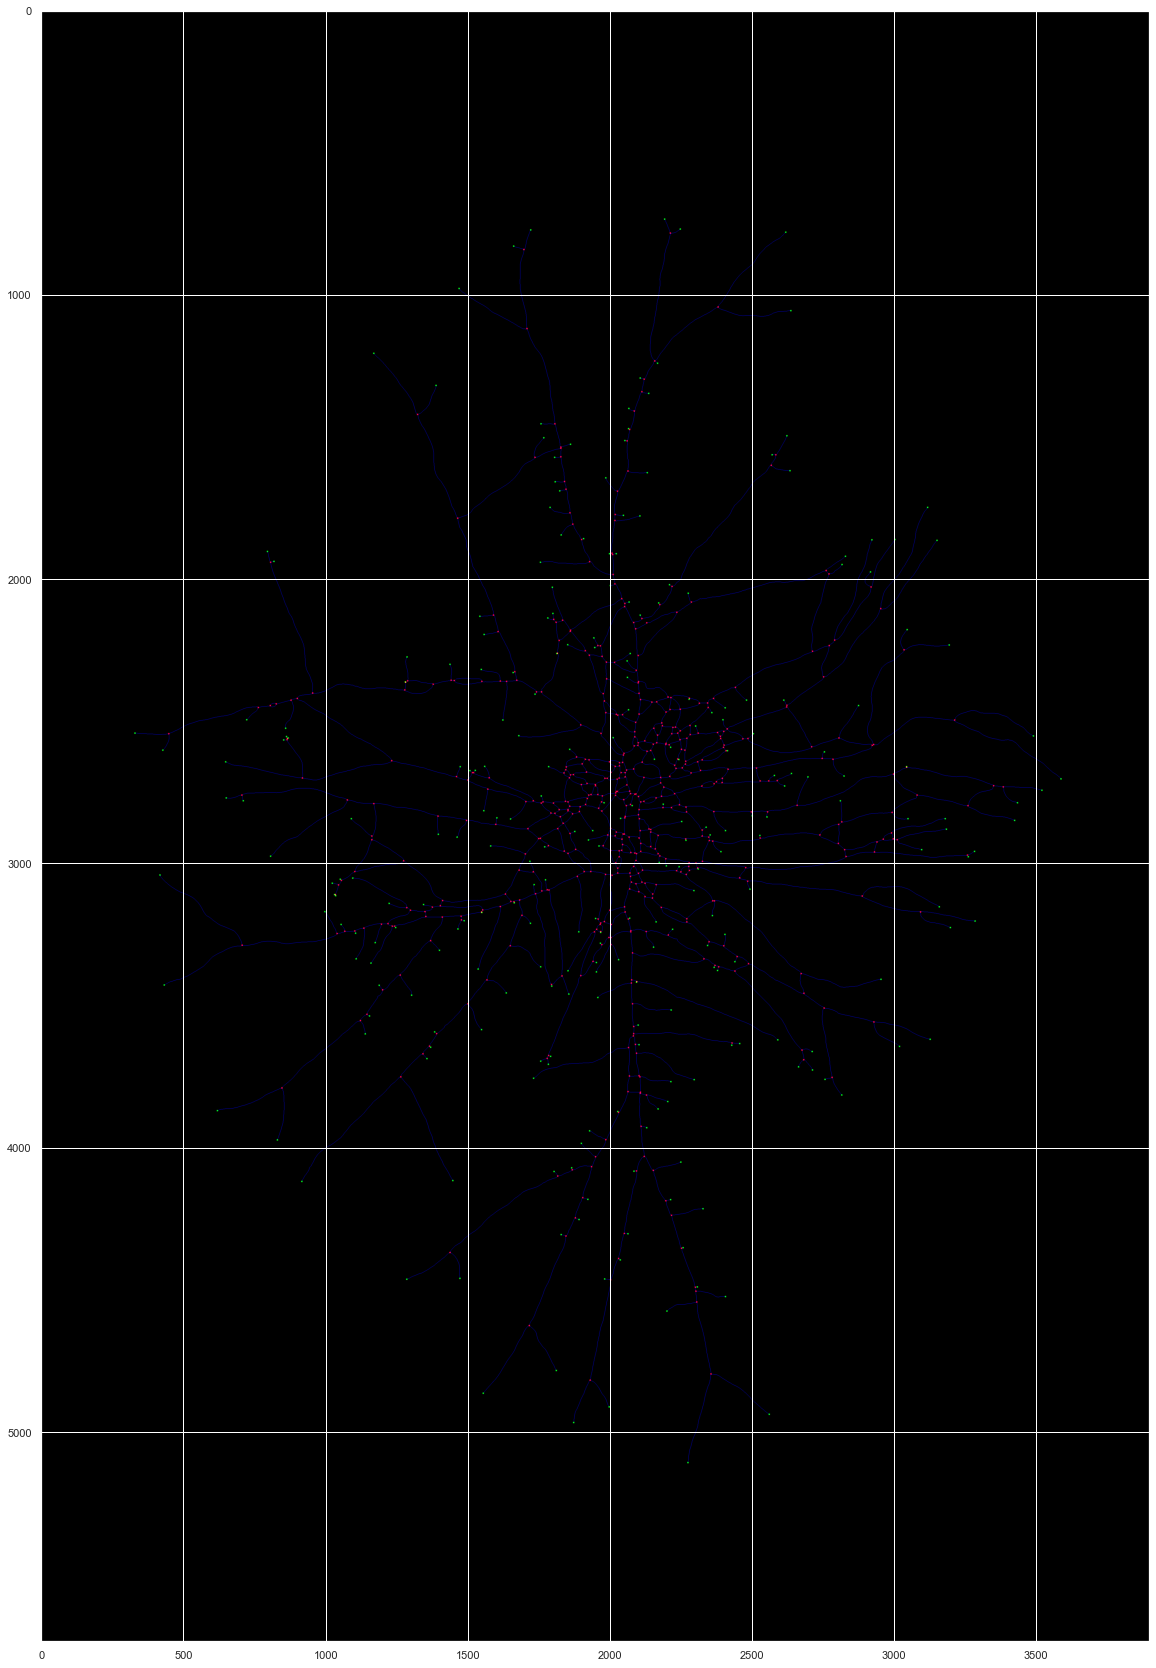

In [27]:
composite = np.array([mark_branches, mark_tips, padded_skeleton], dtype=np.uint8)*255

composite = np.swapaxes(composite, 0, 2)
composite = np.swapaxes(composite, 0, 1)

plt.figure(figsize=[30,30])
plt.imshow(composite)

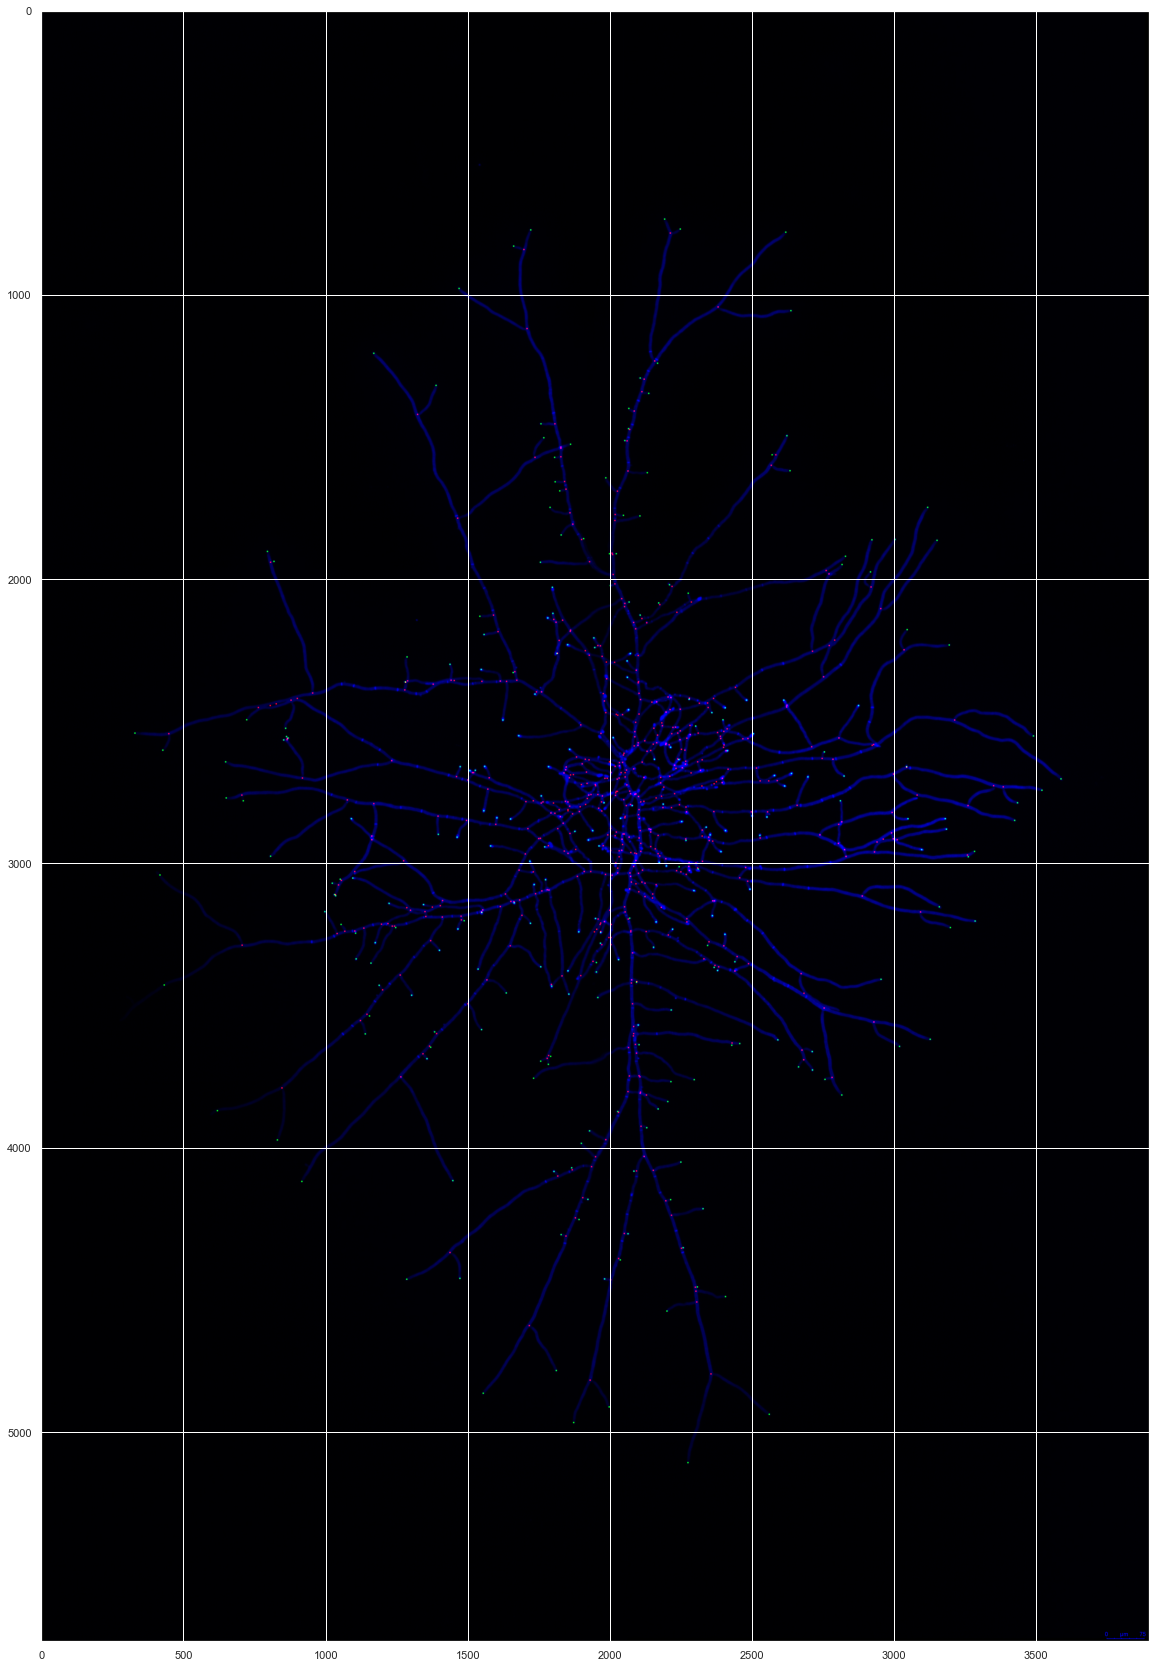

In [28]:
composite = np.array([mark_branches*255, mark_tips*255, pad_img_gray], dtype=np.uint8)

composite = np.swapaxes(composite, 0, 2)
composite = np.swapaxes(composite, 0, 1)

plt.figure(figsize=[30,30])
plt.imshow(composite)

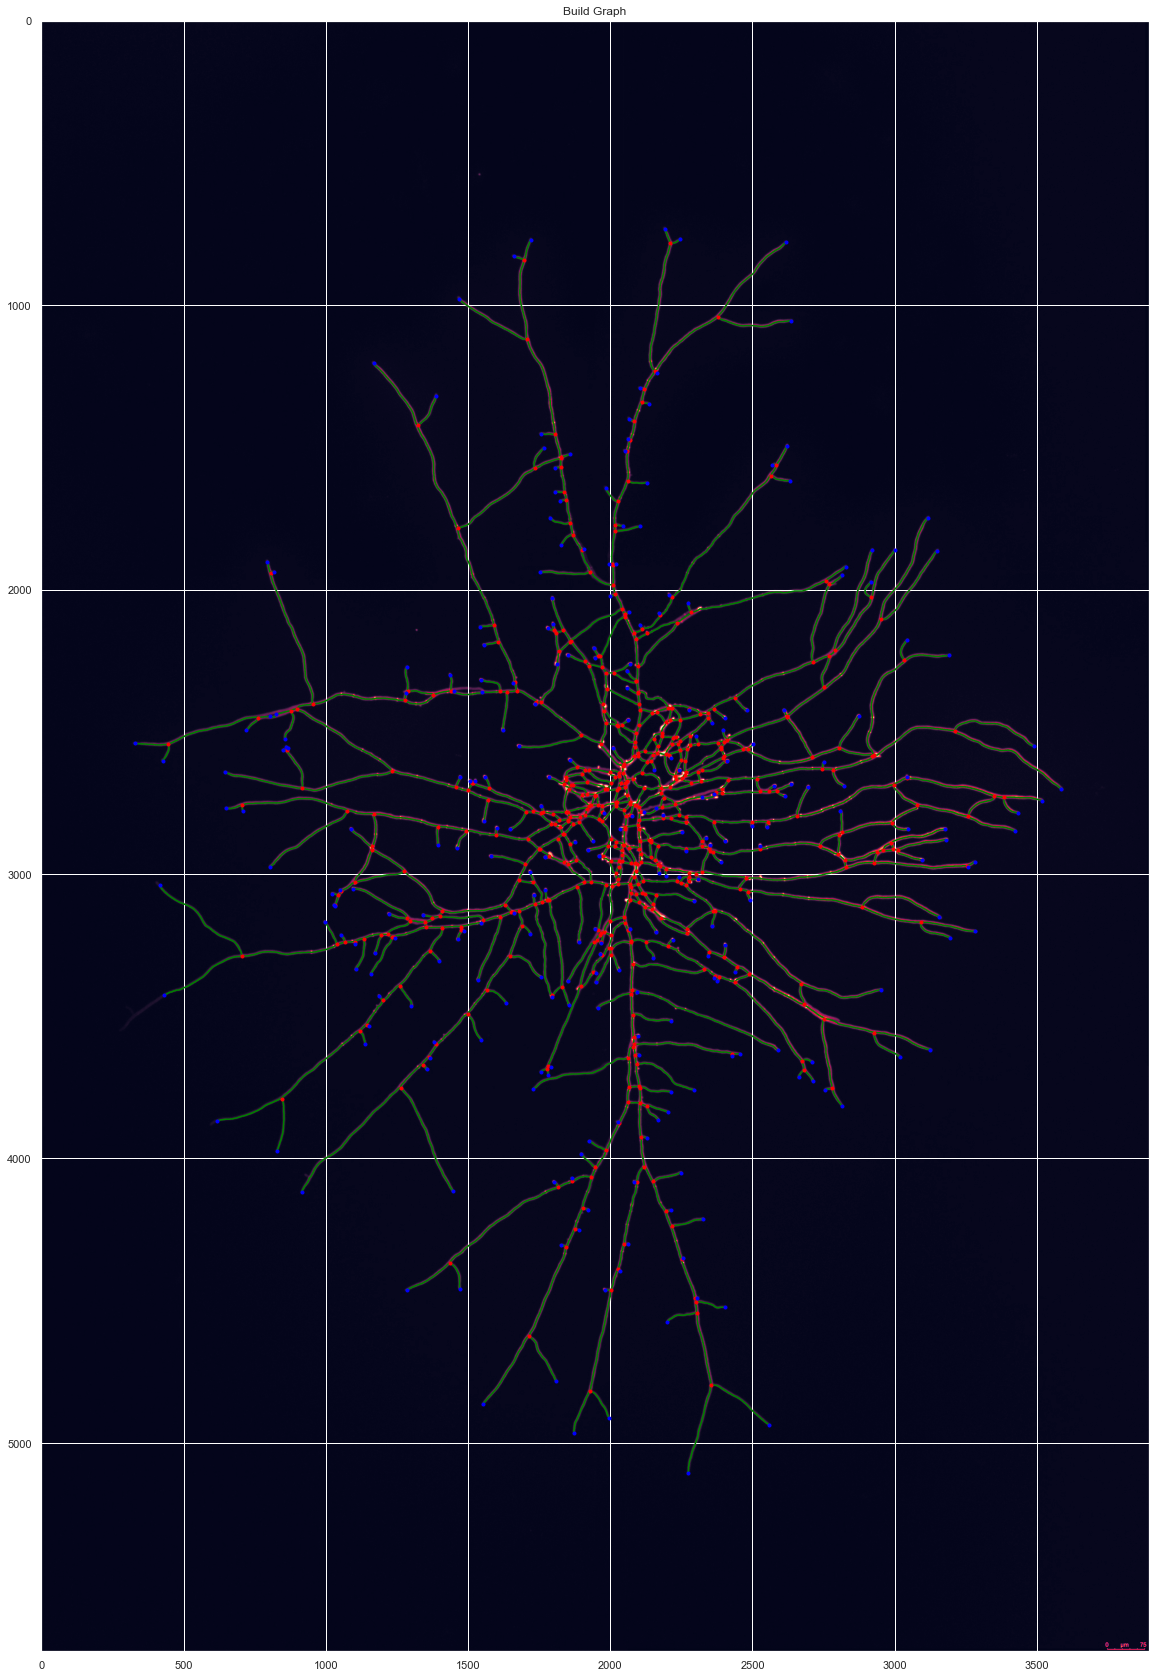

In [38]:
import sknw

# build graph from skeleton
graph = sknw.build_sknw(clean_skeleton)

plt.figure(figsize=[30,30])

# draw image
plt.imshow(img_gray)

# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
plt.plot(bs[:,1], bs[:,0], 'r.')
plt.plot(ts[:,1], ts[:,0], 'b.')

# title and show
plt.title('Build Graph')
plt.show()

# Branches and tips per hyphae length (avg)

In [31]:
pixel_lengths = list()

for (s,e) in graph.edges():
    pixel_lengths.append(len(graph[s][e]['pts']))
    
total_pixel_length = sum(pixel_lengths)

hyphae_per_pixel = 1/50

total_hyphae_count = total_pixel_length*hyphae_per_pixel

In [32]:
len(bs)/total_hyphae_count


0.4223343571741992

# Distance between branches

In [33]:
bb_pixel_lengths = list()

for (s,e) in graph.edges():
    if len(graph.edges(s))>=3 and len(graph.edges(e))>=3:
        bb_pixel_lengths.append(len(graph[s][e]['pts']))

Text(0, 0.5, 'Probability density')

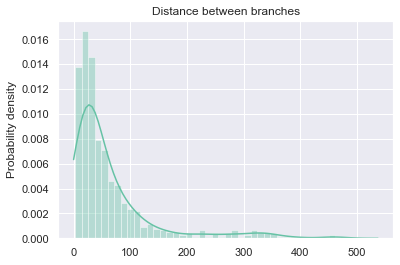

In [34]:
g = sns.distplot(bb_pixel_lengths, kde_kws={'clip': (0.0, 1000.0)})
g.set_title("Distance between branches")
g.set_ylabel("Probability density")

# Distance between tips

In [35]:
tb_pixel_lengths = list()

for (s,e) in graph.edges():
    if (len(graph.edges(s))==1 and len(graph.edges(e))>=2) \
    or (len(graph.edges(s)) >=2 and len(graph.edges(e))== 1):
        tb_pixel_lengths.append(len(graph[s][e]['pts']))

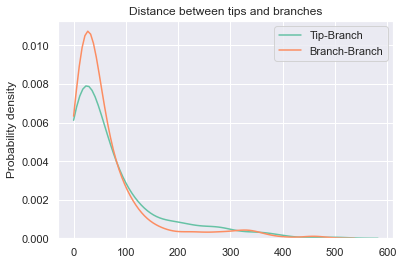

In [36]:
g = sns.kdeplot(tb_pixel_lengths, clip=(0.0, 1000.0), label="Tip-Branch")
h = sns.kdeplot(bb_pixel_lengths, clip=(0.0, 1000.0), label="Branch-Branch")
plt.title("Distance between tips and branches")
plt.ylabel("Probability density")
plt.legend()

In [30]:
# Think about intersections